# **ECG HEARTBEAT CLASSIFICATION WITH ML - Mortara**

by Erica Brisigotti (2097202), Ekaterina Chueva (2072050), Sofia Pacheco Garcia (2070771), Nadillia Sahputra (2070770)

In [1]:
import os
import wfdb
import wfdb.processing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import fftpack, stats, signal
import pywt
from scipy import stats
import time
import copy
import pandas.errors as pe

import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_sample_weight

import tensorflow as tf
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from scikeras.wrappers import KerasClassifier
import joblib
from joblib import Parallel, delayed

In [2]:
# firstly, we set
# - a saving option
FILE_SAVE = False
# - a second saving option for redudant yet maybe worth doing for small datasets
EXTRA_SAVE_FOR_SMALL_DATA = False
# - an option to show the structure of the datasets anayzed (both in general and for the specific chosen example)
SHOW_STRUCTURE = False 
# - the color of the records from a healthier patient in plots
ch = 'forestgreen'
# - the color of the annotations from a healthier patient in plots
cha = 'navy'
# - an additional color for a healthier patient in plots
che = 'deepskyblue'
# - the color of the records from a more sick patient in plots
cs = 'darkorange'
# -  the color of the annotaitons from a more sick patient in plots
csa = 'red' 
# - an additional color for a more sick patient in plots
cse = 'maroon'
# - an option for the classification algorithm (between xgboost and ??)
ML_ALGORITHM = 'xgboost'

In [239]:
# we also define a function that allows to quickly display the distribution of its input
def distribution(arg, a1, a2, title='arg'):
    '''
    function that returns the distribution of arg (which name/meaning is encoded in title)
    '''
    average = np.median(arg)
    std = np.std(arg)
    fig, ax = plt.subplots(1,1, figsize=(12,4))
    info = ax.hist(arg, bins=np.arange(np.min(arg), np.max(arg)+1, 1), align='left', density=True, edgecolor='none', 
                   color='black', alpha=0.8, label = 'distribution of '+title)
    ax.vlines(average, 0, 1, color='magenta', label='average')
    ax.vlines(average+std, 0, 1, color='gold', label='1 $\sigma$')
    ax.vlines(average-std, 0, 1, color='gold')
    ax.set_xlabel(title)
    ax.set_ylabel('density')
    ax.set_xlim(a1, a2)
    ax.set_ylim(0, 1.1*np.max(info[0]))
    ax.set_title('distribution of '+title)
    ax.legend()
    plt.show()

# 1A. Data Preprocessing Example

We set the parameters for the preprocessing part by we choosing two random datasets, *one from the first half and one from second half of the set of patients. Such a split is justified by the knowledge that the second half of patients is generally more sick (since it was purposefully introduced to insert more sick patients).*

To reach such a goal, we upload the two WFDB records using the <code>rdrecord</code> function. They are uploaded as <code>wfdb.Record</code> objects, with many different attributes. Of such attributes, we are interested in the sampling frequency <code>.fs</code> and in the time series, which is stored under as <code>.p_signal</code>.

Similarly, the annotations for the two patients are uploaded using the <code>rdann</code> function, that retuns <code>wfdb.Annotation</code> objects with many attributes. Of such attributes, we are interested in the annotation indexes (saved as <code>.sample</code> ) and symbols (under <code>.symbol</code>).

In [4]:
t_start_all = time.time()

address_1 = "Hour1RawData"
address_2 = "Hour3RawData"
record_1 = wfdb.rdrecord('input_files/'+address_1)
record_2 = wfdb.rdrecord('input_files/'+address_2)
leads = record_1.sig_name

if SHOW_STRUCTURE:
    print('the structure of the wfdb.Record object is:')
    display(record_1.__dict__)
    print('\nabout patient '+address_1)
    with open("input_files/"+address_1+".hea", 'r') as file:
        t = file.read().replace('#',"")
        hea = t.split('\n')
        print('\n',hea[3],": the first two data are info about the age and gender")
        temp = hea[3].split(" ")
        print(temp[1]," is the age of the patient and ",temp[2],"is the gender of the patient")
        print(hea[4],": are the meds the patient is on")
        print(hea[5],": are the notes for the patient")
    print('\nabout patient '+address_2)
    with open("input_files/"+address_1+".hea", 'r') as file:
        t = file.read().replace('#',"")
        hea = t.split('\n')
        print('\n',hea[3],": the first two data are info about the age and gender")
        temp = hea[3].split(" ")
        print(temp[1]," is the age of the patient and ",temp[2],"is the gender of the patient")
        print(hea[4],": are the meds the patient is on")
        print(hea[5],": are the notes for the patient")

In [5]:
# we choose to plot just 2 out of the 12 leads
s0_1 = record_1.p_signal[:,0]
s1_1 = record_1.p_signal[:,7]
s0_2 = record_2.p_signal[:,0]
s1_2 = record_2.p_signal[:,7]
freq = record_1.fs

We plot the records and annotations in both leads for both patients:

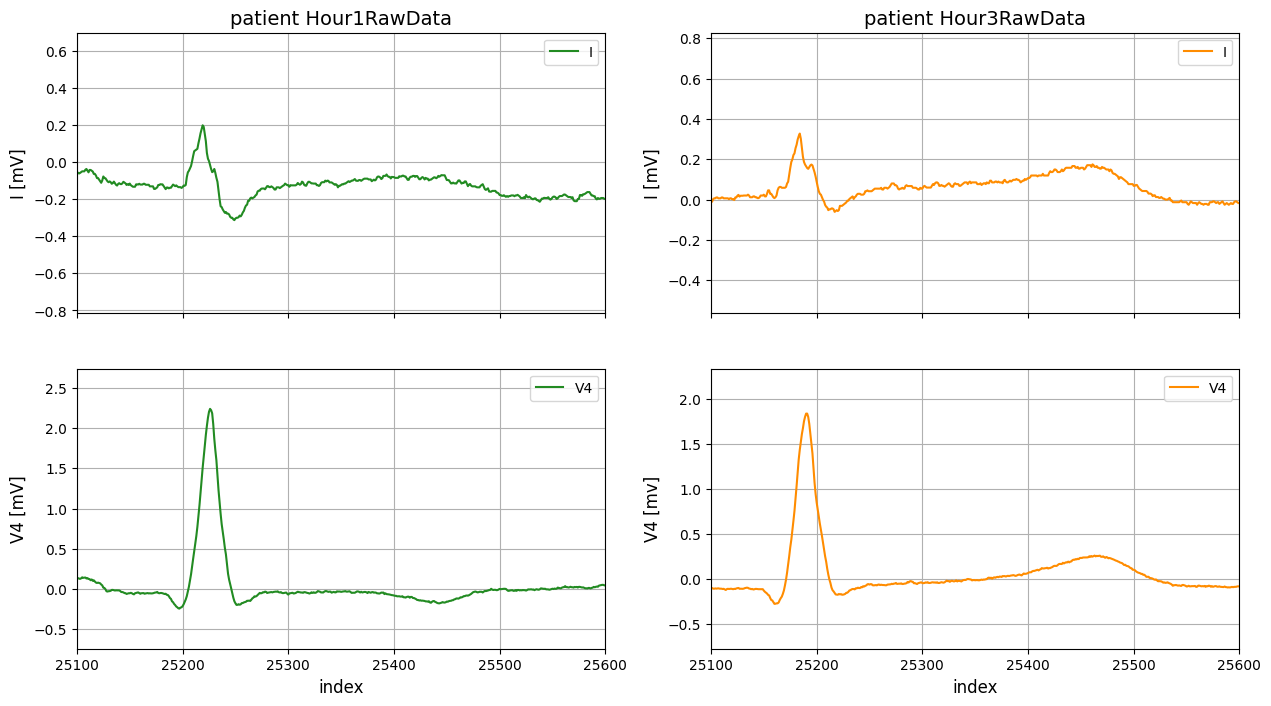

In [6]:
fig1, ax1 = plt.subplots(2,2,figsize = (15, 8), sharex = True)
start_point = 25100
end_point = start_point+500

ax1[0][0].plot(s0_1, '-', label='I', color=ch)
ax1[0][0].set_xlim(start_point, end_point)
ax1[0][0].set_ylim(min(s0_1[start_point:end_point])-0.5, max(s0_1[start_point:end_point])+0.5)
ax1[0][0].set_ylabel('I [mV]', fontsize=12)
ax1[0][0].set_title('patient '+address_1, fontsize=14)
ax1[0][0].legend(ncol=2, fontsize=10)
ax1[0][0].grid()

ax1[0][1].plot(s0_2, '-', label='I', color=cs)
ax1[0][1].set_ylim(min(s0_2[start_point:end_point])-0.5, max(s0_2[start_point:end_point])+0.5)
ax1[0][1].set_ylabel('I [mV]', fontsize=12)
ax1[0][1].set_title('patient '+address_2, fontsize=14)
ax1[0][1].legend(ncol=2, fontsize =10)
ax1[0][1].grid()

ax1[1][0].plot(s1_1, '-', label='V4', color=ch)
ax1[1][0].set_ylim(min(s1_1[start_point:end_point])-0.5, max(s1_1[start_point:end_point])+0.5)
ax1[1][0].set_xlabel('index', fontsize=12)
ax1[1][0].set_ylabel('V4 [mV]', fontsize=12)
ax1[1][0].legend(ncol=2, fontsize=10)
ax1[1][0].grid()

ax1[1][1].plot(s1_2, '-', label='V4', color=cs)
ax1[1][1].set_ylim(min(s1_2[start_point:end_point])-0.5, max(s1_2[start_point:end_point])+0.5)
ax1[1][1].set_xlabel('index', fontsize=12)
ax1[1][1].set_ylabel('V4 [mv]', fontsize=12)
ax1[1][1].legend(ncol=2, fontsize=10)
ax1[1][1].grid()

plt.show()

We implement filtering since the signal is visibly noisy and includes a baseline wonder. We filter with both fast Fourier transform and Wavelet transform tecniques, which are applied serially.

First of all, for the **Fast Fourier Transform**, we want to display and analyze the frequency spectra (which is extracted by the <code>power_fft</code> function).

In [7]:
def power_fft(vect, timestamp):
    '''
    function that returns the fft, absolute value of fft and range of
    frequencies (vect_all_freq) used in the fft
    '''
    vect_fft = fftpack.fft(vect)
    vect_power = np.abs(vect_fft)
    vect_all_freq = fftpack.fftfreq(vect.size, d = timestep)
    return vect_fft, vect_power, vect_all_freq

In [8]:
timestep = 1/freq
norm_fft_1, norm_power_1, norm_all_freq_1 = power_fft(s0_1, timestep)
norm_fft_2, norm_power_2, norm_all_freq_2 = power_fft(s0_2, timestep)

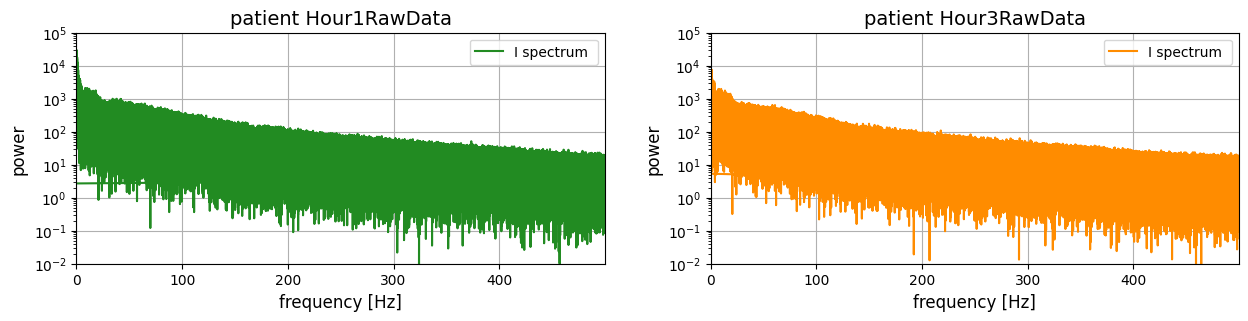

In [9]:
fig2, ax2 = plt.subplots(1, 2, figsize = (15, 3), sharex = True)

ax2[0].plot(norm_all_freq_1, norm_power_1, '-', label='I spectrum ', color=ch)
ax2[0].set_xlim(0,max(norm_all_freq_1))
ax2[0].set_ylim(10**(-2), 10**5)
ax2[0].set_yscale('log')
ax2[0].set_xlabel('frequency [Hz]', fontsize=12)
ax2[0].set_ylabel('power', fontsize=12)
ax2[0].set_title('patient '+address_1, fontsize=14)
ax2[0].legend(loc='upper right', ncol=2, fontsize=10)
ax2[0].grid()

ax2[1].plot(norm_all_freq_2, norm_power_2, '-', label='I spectrum ', color=cs)
ax2[1].set_ylim(10**(-2),10**5)
ax2[1].set_yscale('log')
ax2[1].set_xlabel('frequency [Hz]', fontsize=12)
ax2[1].set_ylabel('power', fontsize=12)
ax2[1].set_title('patient '+address_2, fontsize=14)
ax2[1].legend(loc='upper right', ncol=2, fontsize=10)
ax2[1].grid()

plt.show()

We notice a peak at around 60 Hz, which is due to the power supply of the recording device and must be discarded. We also see high values of the spectrum for low frequency, which should be discarded as well.

Therefore, we decide to implement a band-pass filter: the precise cut frequencies are chosen in the interval $[0.1-55]$ Hz.

In [10]:
down_freq_lim = np.array([0.1, 1, 2])
up_freq_lim = np.array([25, 35, 45])

We notice a peak at around 60 Hz, which is due to the power supply of the recording device and must be discarded. We also see high values of the spectrum for low frequency, which should be discarded as well.

Therefore, we decide to implement a band-pass filter: the precise cut frequencies are chosen in the interval $[0.1-50]$ Hz.

The cut frequency are chosen visually based on the results of their filtering (which is done by the <code>filtered_power</code>) that are shown in the plot below.


In [11]:
def filtered_power(vect_fft, vect_all_freq, down_freq_lim, up_freq_lim):
    '''
    function that filtered the signla starting from its fft, by limiting
    the range of frequencies from vect_all_freq to the range
    [down_freq_lim, up_freq_lim]
    '''
    vect_filtered_fft = vect_fft.copy()
    vect_filtered_fft[np.abs(vect_all_freq) >= up_freq_lim] = 0
    vect_filtered_fft[np.abs(vect_all_freq) <= down_freq_lim] = 0
    vect_filtered = (fftpack.ifft(vect_filtered_fft)).real
    return vect_filtered

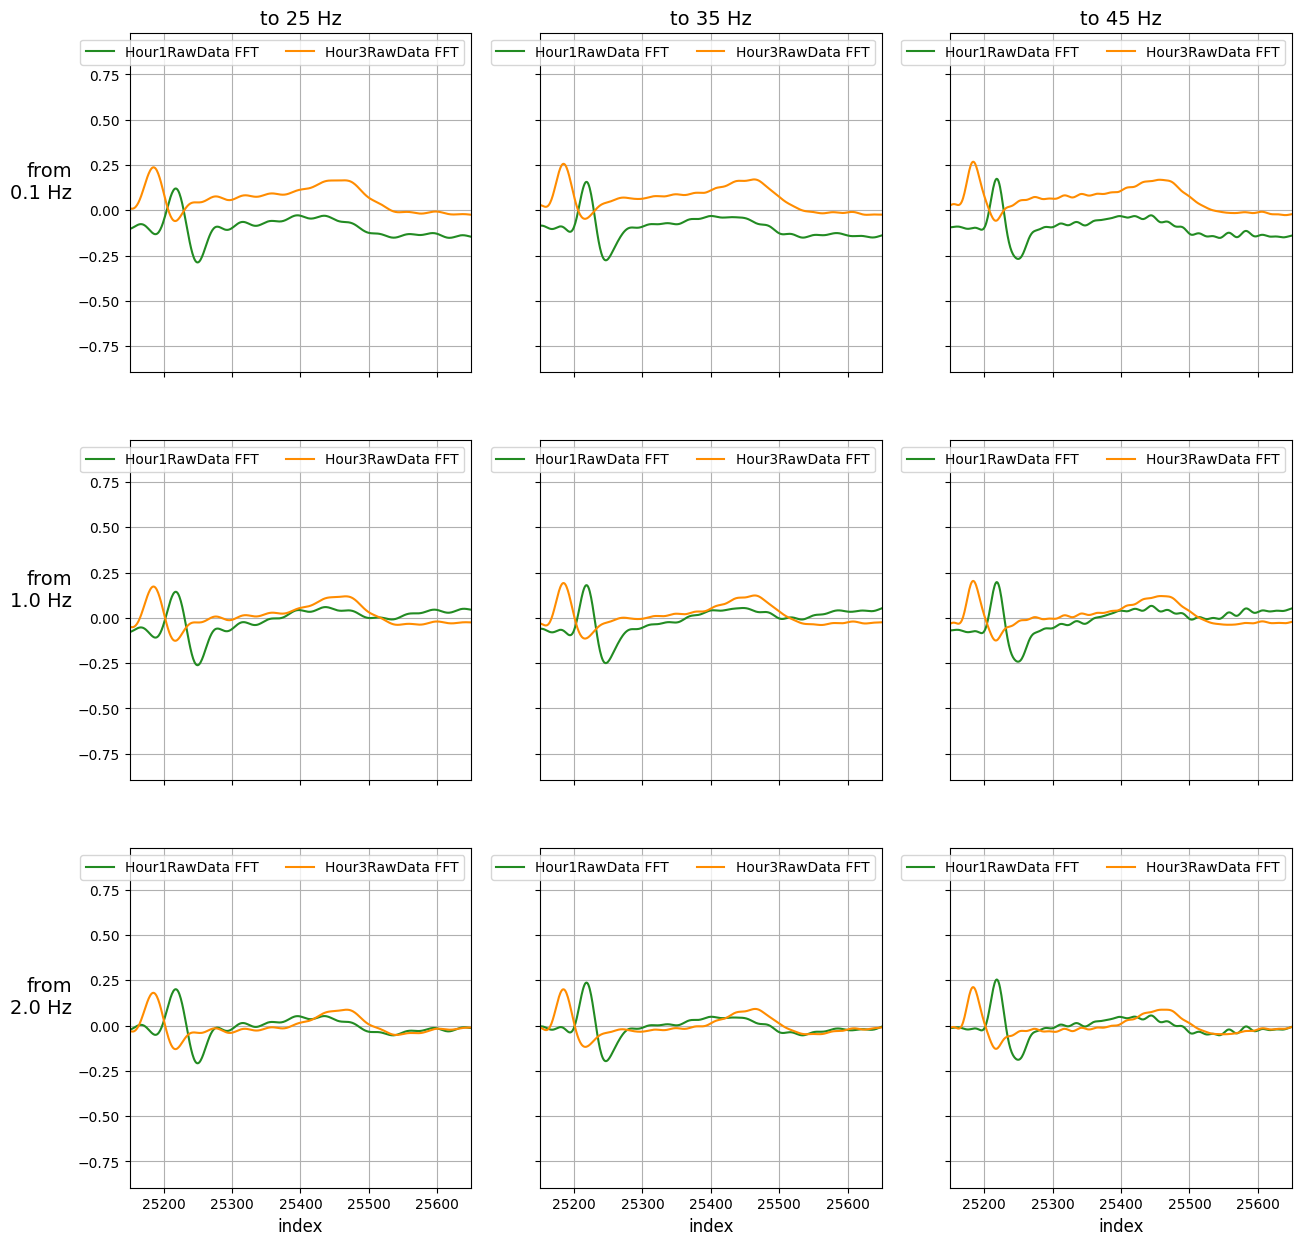

In [12]:
fig3, ax3 = plt.subplots(len(down_freq_lim), len(up_freq_lim), figsize = (15, 15), sharex=True, sharey=True)

start_point = 25150
end_point = start_point+500

for i in range(len(down_freq_lim)):
    for j in range(len(up_freq_lim)):
        norm_filtered_1 = filtered_power(norm_fft_1, norm_all_freq_1, down_freq_lim[i], up_freq_lim[j])
        x_1 = np.arange(0, len(norm_filtered_1), 1)
        norm_filtered_2 = filtered_power(norm_fft_2, norm_all_freq_2, down_freq_lim[i], up_freq_lim[j])
        temp = np.concatenate([norm_filtered_1[start_point:end_point],norm_filtered_2[start_point:end_point]])
        ax3[i][j].plot(norm_filtered_1, '-', label=address_1+' FFT', color=ch)
        ax3[i][j].plot(norm_filtered_2, '-', label=address_2+' FFT', color=cs)
        ax3[i][j].grid()
        ax3[i][j].legend(fontsize=10, ncol=2)
        ax3[i][j].set_xlim(start_point, end_point)
        ax3[i][j].set_ylim(1.3*(min(temp)-0.5), 1.3*(max(temp)+0.5))
        if i==0:
            ax3[i][j].set_title("to "+str(up_freq_lim[j])+" Hz", fontsize=14)
        if j==0:
            ax3[i][j].set_ylabel('from\n'+str(down_freq_lim[i])+" Hz", fontsize=14, rotation=0, ha="right")
        if i==(len(up_freq_lim)-1):
            ax3[i][j].set_xlabel('index', fontsize=12)

From the plots we can see that:
- for small upper limits (e.g. 10 Hz), the filtered signal is too smooth and there is loss of important information
- for intermediate upper limits (e.g. 30 Hz), the filtered signal is still quite noisy
- for nigher upper limits (e.g. 50 Hz), the filtered signal is smoother without major loss of information
- there is no visible variation coming from the different lower limits

Therefore, we decide to set:
- the lower cut frequency as the lowest value, 0.1 Hz
- the upper cut frequency as the highest value available, 50 Hz

In [6]:
down_freq_lim = 1
up_freq_lim = 50

We filter the results shown above with **disctere wavelet transform**. We use a sym4 wavelet and a maximum possible decomposition level.

Lastly, to be safe we want to **eliminate the baseline wander** of the signal to align the isoelectric line. We do this by substracting a low order polynomial function from the signal. </span> Just like before, we use the <code>stats.zscore</code> function to standardize the output. 

In [7]:
def isoelectric_signal(vect, freq, down_freq_lim, up_freq_lim):
    '''
    function that removes baseline wander, performs band-pass filetring using FFT and DWT filtering
    input: raw signal, sampling frequency, lower/upper limits of band-pass filter
    output: filtered signal with mean=0 and standard_deviation=1.
    '''
    timestep = 1/freq
    vect_fft = fftpack.fft(vect)
    vect_power = np.abs(vect_fft)
    vect_all_freq = fftpack.fftfreq(vect.size, d = timestep)
    
    vect_filtered_fft = vect_fft.copy()
    vect_filtered_fft[np.abs(vect_all_freq) >= up_freq_lim] = 0
    vect_filtered_fft[np.abs(vect_all_freq) <= down_freq_lim] = 0
    vect_filtered = (fftpack.ifft(vect_filtered_fft)).real
    
    
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(vect), w.dec_len)
    threshold = 0.04 # Threshold for filtering
    coeffs = pywt.wavedec(vect_filtered, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
    datarec = pywt.waverec(coeffs, 'sym4')
    
    y1 = stats.zscore(datarec)
    x=range(len(y1))

    coefs_filt_1=np.polyfit(x, y1, 8, rcond=None, full=False, w=None, cov=False)

    isoelectric_signal_1=y1-np.polyval(coefs_filt_1, x)
    isoelectric_signal_1 = stats.zscore(isoelectric_signal_1)

    return (isoelectric_signal_1)

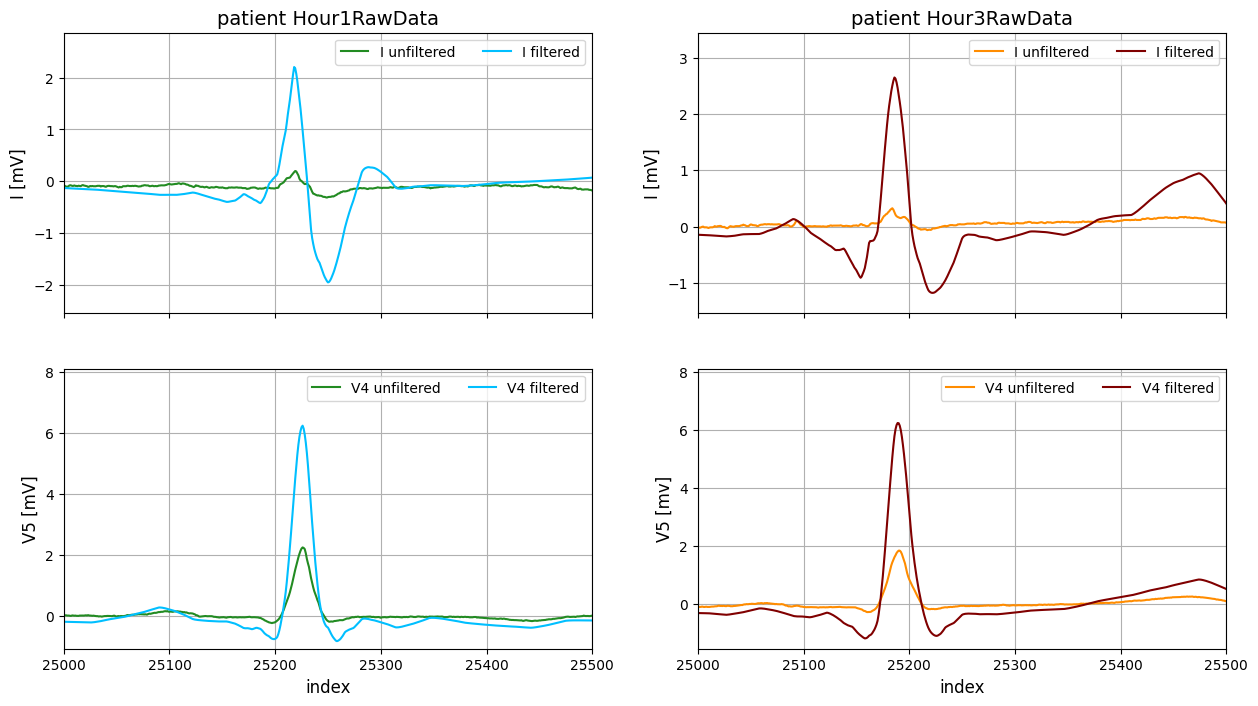

In [8]:
fig4, ax4 = plt.subplots(2,2,figsize = (15, 8), sharex = True)
start_point = 25000
end_point = start_point+500

f_s0_1 = isoelectric_signal(s0_1,freq,down_freq_lim, up_freq_lim)
f_s0_2 = isoelectric_signal(s0_2,freq,down_freq_lim, up_freq_lim)

f_s1_1 = isoelectric_signal(s1_1,freq,down_freq_lim, up_freq_lim)
f_s1_2 = isoelectric_signal(s1_2,freq,down_freq_lim, up_freq_lim)

ax4[0][0].plot(s0_1, '-', label='I unfiltered', color=ch)
ax4[0][0].plot(f_s0_1, '-', label='I filtered', color=che)
ax4[0][0].set_xlim(start_point, end_point)
temp = np.concatenate([s0_1[start_point:end_point], f_s0_1[start_point:end_point]])
ax4[0][0].set_ylim(1.3*min(temp), 1.3*max(temp))
ax4[0][0].set_ylabel('I [mV]', fontsize=12)
ax4[0][0].set_title('patient '+address_1, fontsize=14)
ax4[0][0].legend(ncol=3, fontsize=10)
ax4[0][0].grid()

ax4[0][1].plot(s0_2, '-', label='I unfiltered', color=cs)
ax4[0][1].plot(f_s0_2, '-', label='I filtered', color=cse)
temp = np.concatenate([s0_2[start_point:end_point], f_s0_2[start_point:end_point]])
ax4[0][1].set_ylim(1.3*min(temp), 1.3*max(temp))
ax4[0][1].set_ylabel('I [mV]', fontsize=12)
ax4[0][1].set_title('patient '+address_2, fontsize=14)
ax4[0][1].legend(ncol=3, fontsize=10)
ax4[0][1].grid()

ax4[1][0].plot(s1_1, '-', label='V4 unfiltered', color=ch)
ax4[1][0].plot(f_s1_1, '-', label='V4 filtered', color=che)
temp = np.concatenate([s1_1[start_point:end_point], f_s1_1[start_point:end_point]])
ax4[1][0].set_ylim(1.3*min(temp), 1.3*max(temp))
ax4[1][0].set_xlabel('index', fontsize=12)
ax4[1][0].set_ylabel('V5 [mV]', fontsize=12)
ax4[1][0].legend(ncol=3, fontsize=10)
ax4[1][0].grid()

ax4[1][1].plot(s1_2, '-', label='V4 unfiltered', color=cs)
ax4[1][1].plot(f_s1_2, '-', label='V4 filtered', color=cse)
temp = np.concatenate([s1_2[start_point:end_point], f_s1_2[start_point:end_point]])
ax4[1][1].set_ylim(1.3*min(temp), 1.3*max(temp))
ax4[1][1].set_xlabel('index', fontsize=12)
ax4[1][1].set_ylabel('V5 [mv]', fontsize=12)
ax4[1][1].legend(ncol=3, fontsize=10)
ax4[1][1].grid()

plt.show()

# 1B) Data Preprocessing on the entire dataset

We avoid saving the unfiltered signal in a .csv format, but the option is there if needed: in such a case, the data relative to each patient is saved in a dataframe, in which each columns correspond to one lead.

In [16]:
r  = np.genfromtxt("input_files/RECORDS", dtype='str')
records = list(range(1,(len(r)+1)))

if EXTRA_SAVE_FOR_SMALL_DATA:
    t1 = time.time()
    for path in records:
        # Load the record
        path = str(path)
        record = wfdb.rdrecord("input_files/Hour"+path+"RawData")
        signal = record.sig_name
        df = pd.DataFrame()
        for i in range(0,len(signal)):
            df[signal[i]] = record.p_signal[:, i]

        # Save the DataFrame to a CSV file
        outfn = 'output_files/'+'data'+path+'.csv'
        df.to_csv(outfn, index=False)
    t2 = time.time()
    print('the metadata saving took',t2-t1,'seconds')

Finally, we save the filtered signal in a .csv format: the data relative to each patient is saved in a dataframe, in which each columns correspond to one lead.

In [17]:
r  = np.genfromtxt("input_files/RECORDS", dtype='str')
records = list(range(1,(len(r)+1)))
FILE_SAVE = True
if FILE_SAVE:
    t1 = time.time()
    # for every file provided
    for path in records:
        path = str(path)
        # we load the record
        record = wfdb.rdrecord("input_files/Hour"+path+"RawData")
        # we add the names of the missing leads (which can be computed from the 8 that are already measured)
        signal = record.sig_name 
        moreleads = ['III', 'aVR', 'aVL', 'aVF']
        signal= np.append(signal,moreleads)
        # we add the missing leads
        psig = record.p_signal
        III = record.p_signal[:,2]-record.p_signal[:,1]
        aVR = (-record.p_signal[:,1]-record.p_signal[:,2])/2
        aVL = (record.p_signal[:,1]-III)/2
        aVF = (record.p_signal[:,2]+III)/2
        # and fix their shape
        III = np.reshape(III,(len(psig),1))
        aVR = np.reshape(aVR,(len(psig),1))
        aVL = np.reshape(aVL,(len(psig),1))
        aVF = np.reshape(aVF,(len(psig),1))
        psig = np.hstack((psig,III,aVR,aVL,aVF))
        # we initialize a dataframe in which we're going to save the filtered signal
        df = pd.DataFrame()
        mask = np.arange(0, record.p_signal.shape[0], 1)
        
        # for every lead
        for i in range(0,len(signal)):
            # we save the relative signal
            df[signal[i]] = isoelectric_signal(psig[mask, i],freq,down_freq_lim, up_freq_lim)            

        # Save the DataFrame to a CSV file
        outfn = "output_files/"+"data"+path+'_2filtered.csv'
        df.to_csv(outfn, index=False)
    t2 = time.time()
    print('the filtered data saving took',t2-t1,'seconds')

the filtered data saving took 1444.082210302353 seconds


In [9]:
# for future purposes, we add the new leads to the stored list of leads 
leads = record_1.sig_name
if len(leads)<=8:
    moreleads = ['III', 'aVR', 'aVL', 'aVF']
    leads= np.append(leads,moreleads)

In [10]:
main_lead = 'II'

# 2) R-peaks detection

Since we have the filtered signal $y$, we can implement an algorithm for the detection of the R peaks of the wave based on source [3].
 
Our algorithm finds the peaks by minimizing the error $\varepsilon$ between the parabola fit of consecutive signal windows and the actual signal. We use the quadratic mean parabola-fit error $\varepsilon (i)$ : 
 
$$ \varepsilon(i)=\frac{1}{2 w+1} \sum_{j=i-w}^{i+w}\left(y(j)-y^{\prime}(j)\right)^2  \; \; \text{for} \; \;
 i \in \{w, w+1, w+2, \cdots, N-w-1\} $$ 
 
where:  
- $j \in\{i-w, i-w+1, \cdots, i, i+1, i+2, \cdots, i+w-1, i+w\}$
 
- $w$ is half of the window size, i.e. is a positive number such that $2w +1 = m< N $. Particularly, $m=2w+1$ is the length of both $y(j)$ and $y\prime(j)$ and of the window that should contain the R-peak
 
- $y(j)$ is the sequence defined by fragmenting the filtered signal $y$
 
- $y\prime(j)=a(i-j)^2+v$ is the sequence defined by the parabola fit, which has vertex at index $i$: 

 
The window size for R peak detection is defined by the average duration of the QRS complex (from 70 to 100 ms). 
Rounding down the QRS size (to 60 ms) and diving by 2 to get half of the window size, we get $ W = 0.060 \text{s} \: / \: 2 = 0.030 \text{s} $.
This can be converted into indexes/AU by multiplying by the sampling frequency of the dataset $f_s$
$$w = 0.030 \: \text{s} \cdot f_s$$ 
     
     
So, our goal is to calculate the parameters that make $y^{\prime}(j)$ to best fit $y(j)$. We simplify the task by changing variable to $x=(i-j)^2$. In this way, we can treat the problem as a linear regression $y^{\prime}(j)=ax+v$, where the vertex of the parabola will be located at $(i,v)$. 
 
The two fitting parameters are computed such that:
 
$$a=\frac{m \sum_{j=l_1}^{l_2} x(j) y(j)-\sum_{j=l_1}^{l_2} x(j) \sum_{j=l_1}^{l_2} y(j)}{m \sum_{j=l_1}^{l_2} x^2(j)-\left(\sum_{j=l_1}^{l_2} x(j)\right)^2}$$ 
 
$$v=\frac{\sum_{j=l_1}^{l_2} x^2(j) \sum_{j=l_1}^{l_2} y(j)-\sum_{j=l_1}^{l_2} x(j) y(j) \sum_{j=l_1}^{l_2} x(j)}{m \sum_{j=l_1}^{l_2} x^2(j)-\left(\sum_{j=l_1}^{l_2} x(j)\right)^2}$$ 
 
where $l_1=i-w$, $l_2=i+w$ are the limits of the sums. 
 
In this way, we generate a parabola $y^{\prime}$ that can adjust to the values in the time window (which will go through the entire signal). When the processed signal $y(i)$ reaches a peak, the fitting algorithm finds a parabola such that the vertex of the parabola will coincide with the maximum or minimum point of the wave. If the assumption for a parabola-shaped peak is correct, the fit is be very close to the actual signal. 
 
Nevertheless, such a fit can also resemble parts of the signal that are similar to straight lines since the corresponding values of $\varepsilon(i)$ are low. To avoid finding "false" r-peaks, we place a lower bound to the $a$ coefficient of the parabola to differenciate a straight line ($a \rightarrow 0$) from a wave.

In [19]:
peak_width=0.018
freq=1000
w = int(peak_width*freq) #number of samples in half of the window
m = 2*w+1 #number of samples in a window

In [20]:
def yfit(yn, fs=freq, peak_width=peak_width): 
    '''    
    This function receives as input parameters yn (ECG filtered signal), fs (frequency with which the signal was sampled) 
    and peak_width (approximate half-width of an R peak).     
    The function performs a linear regression for each window of the signal, obtaining the coefficients of the linear fit.    
    It also calculates the quadratic mean parabola-fit error 𝜀(𝑖) for each window.
    Three arrays are obtained as an output: the first one, eps_i, containins the mean parabola fit error for each window.
    The other two, a and v, correspond to the coefficients of the fit for each window.   
    '''
    
    w = int(peak_width*fs) #number of samples in half of the window
    m = 2*w+1 #number of samples in a window
    
    #i is a sequence that goes from w(half size of a window) to N-w being N the total number of data
    i = np.arange(w,len(yn)-w)
    #j is a matrix, each row is the array of the indexes of a window
    j = np.zeros((len(i),m-1))
    for k in range(len(i)):
        j[k] = np.arange(k,k+m-1)

    #x is the change of variable such that instead of a 2nd order fit, we can perform a linear fit
    x = (j[0]-i[0])**2
    
    #yj is a matrix, each row is an array with the signal (data) values for each of the indexes of a window
    yj = yn[j.reshape(j.shape[0]*j.shape[1])].values.reshape(j.shape[0], j.shape[1])

    #a and v are the parameters of the fit such that yj_fit=ax+v. They both are arrays containing the parameters for each i.
    a = ((m*np.sum((x*yj), axis=1))-(np.sum(x)*np.sum(yj, axis=1)))/(m*np.sum(x**2)-(np.sum(x))**2)
    v = ((np.sum(x**2)*np.sum(yj, axis=1))-(np.sum((x*yj), axis=1)*np.sum(x)))/(m*np.sum(x**2)-(np.sum(x))**2)
    
    #yj_fit=ax+v is a matrix that contains in each row the fitted signal for each window 
    yj_fit = (np.tile(a.reshape(len(a)), (m-1,1)).T)*x + (np.tile(v.reshape(len(v)), (m-1,1)).T)

    #eps_i is the Quadratic mean parabola-fit error  𝜀(𝑖) for each i
    eps_i = (1/(2*w+1))*np.sum(((yj-yj_fit)**2), axis=1)
    
    return(eps_i, a, v)

In [21]:
def R_fit(yn, fs=freq, peak_width=peak_width): 
    '''    
    This function receives as input parameters yn (ECG filtered signal), fs (frequency with which the signal was sampled) 
    and peak_width (approximate half-width of an R peak). 
    
    The function returns an array R_i with the indexes of the R peaks, found by impossing the corresponding conditions     
    on the output vectors of the yfit function on the signal (a and v fit coefficients and the error).
    
    Conditions:
    1) The parabola fit error must be a local minimum    
    2) We impose a lower bound in the 'a' coefficient of the linear regression to get rid of false Rpeaks on straight lines.
    '''
    
    w = int(peak_width*fs) #number of samples in half of the window
    m = 2*w+1 #number of samples in a window
    
    y_fit = yfit(yn, fs, peak_width)
    i = np.arange(0,len(y_fit[1]),1, dtype=int)
    a = y_fit[1]
    v = y_fit[2]
    
    #CONDITIONS
    #condition 1: it checks that the R points are minima of the Quadratic mean parabola-fit error  𝜀(𝑖)
    c = np.arange(len(yn)-m+1)[2:]
    cond_min_1 = y_fit[0][c-2]>y_fit[0][c-1]
    cond_min_2 = y_fit[0][c-1]<y_fit[0][c]
    cond_min_eps = cond_min_1 & cond_min_2
    #condition 2: threshold for the a coefficient of the fit to avoid cases in which 𝜀(𝑖)->0 in straight lines
    R_a_mask = abs(y_fit[1])>1.65e-2

    # reshaping to fill in with zeros at the beginning and end (since during the first and last w there are no peaks)
    zeros = np.zeros(w+1)!=0
    zeros2 = np.zeros(w)!=0
    cond_1 = np.concatenate((zeros, cond_min_eps, zeros))
    cond_2 = np.concatenate((zeros2, R_a_mask, zeros2))
    a_fixed=np.concatenate((zeros2, y_fit[1], zeros2))
    v_fixed=np.concatenate((zeros2, y_fit[2], zeros2))

    # using masks to find the desired results
    R_i_mask=cond_1&cond_2
    R_i=(np.where(R_i_mask))[0]
    a=a_fixed[R_i]
    v=v_fixed[R_i]
    
    return R_i, a, v

In [22]:
def align_to_longest(r, test, level):
    '''
    function that returns a one-to-one correspondance between:
    # - the vector of reference rpeaks
    # - the peaks to test
    # the third input (level) is a treshold to be set based on the RR distance
    '''
    
    # we make sure that everything is a numpy array
    r = np.array(r)
    test = np.array(test)
    
    # we make deep copies that we can safely modify during the loop without loss of data
    r_peaks = copy.copy(r)
    test_peaks = copy.copy(test) 
    # and we initialize the vectors in which we are going to save the results
    # we initialize to weird numbers so that we can make sure that all values have been changed by the end of the algorithm
    bool_record = np.ones(len(r), dtype=int)*(-55)
    idx_record = np.ones(len(r))*(-55)

    # for every peak in the longest peak
    for i in range(len(r)):
        # we make sure that there are still peaks to be compared with it
        if (len(test_peaks)>0):
            # we get the current element to examine, which every time is the first element of the array (since we later
            # delete the elements aftering examining them)
            r_index = r_peaks[0]
            # calculate the distance from all the remaining test peaks
            distance = np.abs(test_peaks - r_index)
            # and sort such distances to find the minimum distance and the index (of rpeaks) corresponding to it
            sort_distance = pd.DataFrame({'distance': distance}).sort_values(by=['distance'])
            # we set the corresponding index to be the 
            min_distance = sort_distance.distance.values[0]
            # we get the index corresponding to the minimum distance
            min_distance_idx = sort_distance.index.values[0]
            # If the minimum distance is appropriate
            if min_distance<level:
                # we save the positive finding
                bool_record[i] = 1
                # and the index corresponding to that finding
                idx_record[i] = test_peaks[min_distance_idx]
                # and remove the information corresponding to this configuration,
                # to avoid repetitions and grant a one-to-one correspondance
                test_peaks = np.delete(test_peaks, min_distance_idx)
                r_peaks = np.delete(r_peaks, 0 )
            # otherwise (if the closest value is too far away to be considered close)
            else:
                # we save the negative finding
                bool_record[i] = 0
                # and signal the lack of a corresponding index with a non-numeric value
                idx_record[i] = np.nan
                # we forget about the data 
                #test_peaks = np.delete(test_peaks, min_distance_idx)
                r_peaks = np.delete(r_peaks, 0 )
        # if all peaks have already been compared, we for sure have a negative result
        else:
            # we save the negative finding
                bool_record[i] = 0
                # and signal the lack of a corresponding index with a non-numeric value
                idx_record[i] = np.nan
    return bool_record, idx_record

In [24]:
def align(r, ann_idx, ann_symb, level):
    '''
    function that returns a one-to-one correspondance between:
    - the vector of r-peaks r
    - the annotations indexes ann_idx
    while estabilishing this correspondance, the third input (ann_symbol) is altered identically to ann_idx
    since the desired outcome of the code is to find the ann_symb corresponding to the r-peaks. 
    the last input, level, is a treshold which correspond to the maximum distance for compatibility
    '''
    if len(r) != len(np.unique(r)):
        print('input has repetition!!! but we took care of it inside the function')
        r = np.unique(r)
                     
    # we make deep copies that we can safely modify during the loop without loss of data
    rpeaks = copy.copy(r)
    ann_indexes = copy.copy(ann_idx) 
    ann_symbols = copy.copy(ann_symb)
    # lastly, we initialize the vectors in which we are going to save the results
    # - the r-peaks for which we find a corresponding annotation
    real_r_peaks = list()
    # - the annotation (symbols) for which we find a corresponding rpeak
    real_ann_symbols = list()
    ann_aligned = list()
    # - a dummy initialization needed to enter the while-loop
    sort_distance = np.zeros(100)
    # - a register for the rpeaks (that will work, later on, as a boolean mask to be applied to the input r)
    r_register = np.zeros(len(r),dtype=bool)
    # - a list in which we save every peak once (if found in both rpeak and ann, the rpeak value is kept)
    val = []
    # - to lists where we keep record of where the values in val come from
    ann_bool = []
    rpeak_bool = []
    
    i=-1
    while ((i<=len(ann_idx)+1) & (len(sort_distance)>1) & (len(ann_indexes)>=1)):
        i +=1
        # we get the current element to examin
        ann_index = ann_indexes[0]
        # calculate the distance of the many (remaining) rpeaks from it
        distance = np.abs(rpeaks - ann_index)
        # and sort such distances to find the minimum distance and the index (of rpeaks) corresponding to it
        sort_distance = pd.DataFrame({'distance': distance}).sort_values(by=['distance'])
        # we set the corresponding index to be the 
        min_distance = sort_distance.distance.values[0]
        # If the minimum distance is appropriate
        if min_distance<level:            
            # we get the index corresponding to the minimum distance
            min_distance_idx = sort_distance.index.values[0]
            # we save the rpeak corresponding to minimum distance
            real_r_peaks.append( rpeaks[ min_distance_idx ] )
            # And the annotation index
            ann_aligned.append(ann_indexes[0])
            # and save the corresponding annotation
            real_ann_symbols.append( ann_symbols[0] )
            # we find where the peak was originally
            asmr = np.where(r == rpeaks[ min_distance_idx ])
            # to fill in the boolean mask 
            r_register[asmr] = True
            # we save the results:
            val.append(rpeaks[min_distance_idx])
            ann_bool.append(1)
            rpeak_bool.append(1)
            # and remove the annotations (both index and symbol) and rpeak corresponding to this configuration,
            # to avoid repetitions and grant a one-to-one correspondance
            rpeaks = np.delete(rpeaks, min_distance_idx)
            ann_indexes = np.delete(ann_indexes, 0 )
            ann_symbols = np.delete(ann_symbols, 0 )
            
        # otherwise (if the closest value is too far away to be considered close)
        else:
            val.append(ann_indexes[0])
            ann_bool.append(1)
            rpeak_bool.append(0)
            
            # we forget about the data corresponding to this annotation since there's no correspondance in the rpeak
            ann_indexes = np.delete(ann_indexes, 0 )
            ann_symbols = np.delete(ann_symbols, 0 )
    if len(rpeaks)>0:
        val.extend(rpeaks) # I'm really not sure about this line
        ann_bool.extend(np.zeros(len(rpeaks),dtype=int))
        rpeak_bool.extend(np.ones(len(rpeaks),dtype=int))

#     print(len(r_register),'is the length of the boolean mask r_register, just like the lenght of the input ',len(r))
#     print(sum(r_register),' is number of Trues in len(r_register), just like the length of real_r_peaks', 
#           len(real_r_peaks))

    return ann_aligned, real_r_peaks, real_ann_symbols, np.array(val), np.array(ann_bool), np.array(rpeak_bool), r_register

In [25]:
def bool_mask_removing_repetitions(a2):
    '''
    the function produces a boolean mask that helps keep track of the changes that happen from a to np.unique(a)
    '''
    # we get the unique values and how many times each of them is present
    a, counts = np.unique(a2, return_counts=True)
    # we intialize the boolean mask in output, which dimensions must match the ones of the input and is initally all positives
    output = np.ones(len(a2), dtype=bool)
    # for the elements that are repeated
    tocheck = a[counts >1]
    for tc in tocheck:
        # we get the indexes of the actual repetitions (i.e. all indexes beside the first occurrence)
        idx = np.where(a2 == tc)[0][1:]
        # and make sure to negate the boolean mask in such indexes
        output[idx] = np.zeros(len(idx),dtype=bool)
    return output

In [27]:
def rpeaks_per_patient(x_d, data, lev1, n_leads, annotations=False, ann_idx=None, ann_symbol=None, lev2=None,):
    '''
    The following function aligns the r-peaks found in the 12 leads and decides which ones to keep based on how many times 
    (out of 12) they are found. The inputs are:
    - x_d: the dictionary, in which is key is a lead name and corresponds to a list of r-peaks
    - lev1: an input theshold (to be set based on the RR distance - see align_to_longest function)
    - n_leads : minimum number of matching leads for a peak to be accepted
    - annotations: an option tg=hat, if True, filters also to match annotations and will return two accuracy scores
    - ann_idx: a numpy array of annotations indexes
    - ann_symbol: a list of annotations symbols (its length must match the one of ann_idx
    - l
    '''
    # we extract the names fl
    names = list(x_d.keys())
    # we find the longest one
    l = [len(x_d[name]) for name in names]
    # we find the corresponding index
    best_idx = np.argmax(l)
    # and we call the corresponding lead "best_lead"
    best_lead = names[best_idx]
    # we now create a dataframe in which we are going to save everything
    # it is going to have as many rows has the lead with most peaks
    peaks = pd.DataFrame({ str(best_lead) : x_d[best_lead] })
    # we now want to fill the dataframe with the remaining information
    # for each one, we try to align the results to the best_lead
    reference = x_d[best_lead]
    
    # for every lead (including the best one, so we make sure to save all the indexes in the same place)
    for ol in names:
        # we extract the test peaks
        test = x_d[ol]
        # to feed them to a function that returns the columns of the dataframe to be filled
        # the first column contains booleans that signal if a correspondance for the peak was found in the dataset
        # the second column contains the indexes that are potentially found in the correspondance (otherwise, they are NaN)
        peaks[ol], peaks[ol+'_idx'] =  align_to_longest(reference, test, lev1)
    # we calculate the number of times in which each peak is found
    peaks['n'] = peaks[names].sum(axis=1)
    # and decide if the peaks must be kept based on an input theshold
    peaks['to_keep'] = peaks['n']>=n_leads   
    # We delete the peaks that we don't keep
    true_peaks = peaks[peaks['to_keep']==True]
    true_peaks = true_peaks.reset_index(drop = True)
    # we find the average location of each peak, selecting only the only ones to keep
    name_idx = [name+'_idx' for name in names]
    true_peaks['loc'] = (true_peaks[name_idx].mean(axis=1)).astype(int)
    rpeaks = true_peaks['loc'].to_numpy()
    where_repetitions = bool_mask_removing_repetitions(rpeaks)
    rpeaks = np.unique(rpeaks)
    
    # if we can compare with annotations
    if annotations:
        # we compare with annotations
        ann_aligned, r_aligned, ann_symbols_aligned, val, ann_bool, rpeak_bool, r_register = align(rpeaks, ann_idx, ann_symbol, lev2)

        # we count the:
        # - true positives
        true_positive = np.sum( ( (np.array(ann_bool)==1) & (np.array(rpeak_bool)==1) ))
        # - false positives
        false_positive = np.sum( ( (np.array(ann_bool)==0) & (np.array(rpeak_bool)==1) ))
        # - false negatives
        false_negative = np.sum( ( (np.array(ann_bool)==1) & (np.array(rpeak_bool)==0) ))
        # - true negatives
        true_negative = len(data)-len(val)
        # and concatenate the results in a (non-normalized) matrix
        conmat_patient = np.array([[true_positive, false_negative],[false_positive,true_negative]]) 
        return r_aligned, peaks['to_keep'].to_numpy(), best_lead, where_repetitions, r_register, ann_symbols_aligned, conmat_patient
    else:
        return rpeaks, peaks['to_keep'].to_numpy(), best_lead, where_repetitions

In [34]:
def process_record_corrected(path, coef_parab):
    '''
    function that processes a single file by applying the previously defined functions
    '''
    # Load the record
    path = str(path)
    # we create a dictionary in which we going to save the r-peaks obtained in every lead
    xd = {}
    # and we do the same for saving the coefficients of the parabola fits
    ecia = {}
    lia = {}
    # we initialize the estimates of the RR length
    stat_RR = np.zeros(len(leads))
    stat_RR2 = np.zeros(len(leads))
    
    # for every lead
    for i,lead in enumerate(leads):
        # we read the corresponiding data
        data = pd.read_csv("output_files/data"+path+"_2filtered.csv")[lead]
        # we find its R-peaks 
        rpeak, temp1, temp2 = R_fit(data)
        # we save the corresponding coefficients for the parabola fits
        ecia[lead] = temp1
        lia[lead] = temp2
        # we compute and estimator of th RR lenght for the peaks we just found
        stat_RR[i] = np.median(rpeak[1:]-rpeak[0:-1], )
        stat_RR2[i] = np.mean(rpeak[1:]-rpeak[0:-1])
        # and save the peaks we just found in a dictionary
        xd[lead] = rpeak
        
    # we calculate an estimator of all the RR lengths and use to deduce the maximum distance for peak compatibility
    # (which should generally be smaller than the half of the average RR interval)
    # in this precise case, we choose the median as the estimator since the distribution is quite asymmetric 
    # (so the difference between mean and median is huge)
    # we need to get rid of the NaN that are returned by np.median if no peak is found in a lead
    lev1 = np.nanmedian(stat_RR)/2
    print('maximum distance for compatibility of same peak in different leads:',lev1)
    


    rpeaks, pp, best_lead, where_repetitions = rpeaks_per_patient(xd, data, lev1, 8)
    # we select the data relative to the best lead (now that we know which is)
    ii = xd[best_lead]
    a = ecia[best_lead]
    v = lia[best_lead]

    # we add the R peaks to the dataframe while also adapting them to the frequency reduction that we're about to implement
    rpeaks = np.array(rpeaks)
    final = (rpeaks/4).astype(int)
    df = pd.DataFrame({'R': final}) 
    outfn = "output_files/"+"data"+path+'_12Rpeak.csv'
    df.to_csv(outfn, index=False)
    
    # we save together the parameters for the parabola
    temp = pd.DataFrame({'i': ii,'v':v, 'a':a, 'path': [path]*len(a) })
    # crop them to have a one-to-one correspondence with the R peaks
    temp = (((temp[pp]).reset_index(drop=True))[where_repetitions].reset_index(drop=True))
    
    # and adjust the index column to match the future frequency reduction
    temp['i'] = (temp['i']/4).astype(int)
    coef_parab = (pd.concat([coef_parab, temp])).reset_index(drop=True)
    
    print('process_record_corrected: match in len of output files: ',len(temp)==len(final))
    if len(temp) !=len(final):
        print("current coef_parab and rpeaks lengths don't match")
        print('input lenghts :',len(ii),len(a),len(v) )
        print('pp starts from',len(pp),'and end to ',sum(pp))
        print('where_repetitions starts from',len(where_repetitions),'and end to ',sum(where_repetitions))
        print('r_register starts from',len(r_register),'and end to ',sum(r_register))
        print('output length :', len(coef_parab) )
    
    return final, coef_parab

In [35]:
FILE_SAVE=True

In [36]:
if FILE_SAVE==True: 
    # we initialize the names of files to be processed
    r  = np.genfromtxt("input_files/RECORDS", dtype='str')
    records = list(range(1,(len(r)+1)))
    # and a database in which we're going to save the parameters of the 
    coef_parab = pd.DataFrame({'i': [], 'a':[], 'v':[], 'path': []})

    if __name__ == "__main__":
        t1 = time.time()
        # for every file
        for path in records:
            # we process the data
            rpeaks, coef_parab = process_record_corrected(path, coef_parab)
            # we reset the dataframe indexes (to avoid future bugs)
            coef_parab=coef_parab.reset_index(drop = True)
            
            print(path)
        
        # we reset the dataframe indexes (to avoid future bugs)
        coef_parab=coef_parab.reset_index(drop = True)
        # we make sure that the peaks found are correct (the corresponding parabola fits intersect with the x axis)
        coef_parab['Delta'] = -4*coef_parab['a']*coef_parab['v']
        print('Delta>0 for all peaks :',np.all(coef_parab['Delta']>0))
#         print("rpeaks - coef_parab['i'] :", np.mean(rpeaks - coef_parab['i']), '±', np.std(rpeaks - coef_parab['i']) )
        t2 = time.time()
        print('The R peak data saving took', round((t2-t1)/60,2), 'minutes')

maximum distance for compatibility of same peak in different leads: 311.25
process_record_corrected: match in len of output files:  True
1
maximum distance for compatibility of same peak in different leads: 371.0
process_record_corrected: match in len of output files:  True
2
maximum distance for compatibility of same peak in different leads: 404.0
process_record_corrected: match in len of output files:  True
3
maximum distance for compatibility of same peak in different leads: 333.75
process_record_corrected: match in len of output files:  True
4
maximum distance for compatibility of same peak in different leads: 320.5
process_record_corrected: match in len of output files:  True
5
maximum distance for compatibility of same peak in different leads: 341.5
process_record_corrected: match in len of output files:  True
6
maximum distance for compatibility of same peak in different leads: 265.5
process_record_corrected: match in len of output files:  True
7
maximum distance for compatibili

C:\Users\nadil\anaconda3\envs\torch\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\nadil\anaconda3\envs\torch\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


maximum distance for compatibility of same peak in different leads: 644.5
process_record_corrected: match in len of output files:  True
20
maximum distance for compatibility of same peak in different leads: 613.5
process_record_corrected: match in len of output files:  True
21
maximum distance for compatibility of same peak in different leads: 606.5
process_record_corrected: match in len of output files:  True
22


C:\Users\nadil\anaconda3\envs\torch\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\nadil\anaconda3\envs\torch\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


maximum distance for compatibility of same peak in different leads: 599.5
process_record_corrected: match in len of output files:  True
23
maximum distance for compatibility of same peak in different leads: 586.0
process_record_corrected: match in len of output files:  True
24
Delta>0 for all peaks : False
The R peak data saving took 95.4 minutes


In [63]:
# outfn = "output_files/coef_parab.csv"
# coef_parab.to_csv(outfn, index=False)

In [11]:
coef_parab = pd.read_csv("output_files/coef_parab.csv")
coef_parab

,i,a,v,path,Delta
0,556.0,0.024642,-5.623284,1,0.554277
1,695.0,0.021833,-5.121537,1,0.447271
2,830.0,0.021400,-4.966572,1,0.425133
3,964.0,0.022563,-5.065584,1,0.457178
4,1096.0,0.021240,-4.996527,1,0.424505
...,...,...,...,...,...
70897,847539.0,-0.022921,4.593035,24,0.421116
70898,847668.0,-0.029394,6.413937,24,0.754124
70899,847797.0,-0.033397,5.784591,24,0.772745
70900,847925.0,-0.026892,5.604619,24,0.602885


Now that we've analyzed in details the positions of the peaks, we can artificially reduce the frequency of the dataset to improve computation time. We take care only of the datasets since the R peaks were already adapted during saving.

In [12]:
Resaving filtered file with new frequency, 250Hz
if FILE_SAVE==True: 
    mask = list(np.arange(0, record_1.p_signal.shape[0], 4))
    r  = np.genfromtxt("input_files/RECORDS", dtype='str')
    records = [1] #list(range(2,(len(r)+1)))
    for path in records:
        path = str(path)
        datac = pd.DataFrame()
        data = pd.read_csv("output_files/"+"data"+path+'_2filtered.csv')
        for i in range(0,len(leads)):
            mask = np.arange(0,len(data),4)
            datac[leads[i]] = data.iloc[mask, i]
            outfn = "output_files/"+"data"+path+'_filtered.csv'
            datac.to_csv(outfn, index=False)

In [13]:
new_freq = int(freq/4)

# 3) Segmentation

The following segmentation algorithm is based on the known ratios that can be computed between:
- the average length of the RR interval (~ 800 ms from 600-1000 ms) 
- the average length of the PR interval (~ 160 ms from 120-200 ms)
- the average length of the QT interval (~ 410 ms from 360-460 ms)

Such ratios are used to find the actual length of thePR and QT interval ($L_\text{PR}^i$, $L_\text{QT}^i$) based on the actual length of RR interval $L_\text{RR}^i$ (which can be easily computed). 

$$ L_\text{PR}^i = L_\text{RR}^i \cdot \frac{410 \; \text{ms}}{800 \; \text{ms}} $$

$$ L_\text{QT}^i = L_\text{RR}^i \cdot \frac{160 \; \text{ms}}{800 \; \text{ms}} $$

Once $L_\text{PR}^i$ and $L_\text{QT}^i$ are computed, the hearbeat is identified as:

$$ \left[ x_\text{R-peak}^i - L_\text{PR}^i  , x_\text{R-peak}^i + L_\text{QT}^i \right]  $$

The length of such interval is $\frac{(410+160) \; \text{ms}}{800 \; \text{ms}} = \frac{57}{80} \sim 71.25 \% $.

In [159]:
def segmentation_R(annotations, cp):
    '''
    function that performs a relative window segmentation based on the relative known proportions between RR, PR and QT 
    '''
    ann = annotations
    
    # we initialize the variables we need for the while loop
    patient_start = np.ones(2)*-3
    j = -1
    while np.any(patient_start<0):
        j += 1
        # we calculate the RR intervals
        RR_intervals = (ann[(j+1):]-ann[j:-1])
        # firstly, we crop the RR interval to match the relative proportion of RR:QT=0.8:0.41 
        QT_size = (RR_intervals*0.41/0.8).astype(int)
        PR_size = (RR_intervals*0.16/0.8).astype(int)
        
        patient_start = ann[j:-1] - PR_size
        patient_end = ann[j:-1] + QT_size
        
    # j is the number of annotations ignored from the beginning
    # i is the number of annotations ignored from the end
    # once we've made sure that the annotations are aligned, we delete the first and last one just to be safe
    RR_intervals = RR_intervals[1:-1]
    QT_size = QT_size[1:-1]
    PR_size = PR_size[1:-1]    
    
    patient_start = ann[j+1:-2] - PR_size
    patient_end = ann[j+1:-2] + QT_size

    cp = cp[j+1:-2]


    patient_R_peak = ann[j+1:-2]
    #patient_ann = list(annotations['symbol'][j+1:-2])
        
    return RR_intervals, QT_size, PR_size, patient_start, patient_end, patient_R_peak, cp

In [160]:
FILE_SAVE=True
r  = np.genfromtxt("input_files/RECORDS", dtype='str')
records = list(range(1,(len(r)+1)))

if FILE_SAVE:
    t1 = time.time()
    
    # we want to save a dataframe of heartbeats: to do that, we initialize some temporary means of storage
    # - the number that identifies the patient
    number = np.array([0])
    # - the number that identifies the heartbeat of each patientx
    idx = np.array([0])
    # - the index of the start of the heartbeat
    start = np.array([0])
    # - the index of the end of the heartbeat
    end = np.array([0]) 
    # - the index of the R peak of the heartbeat
    R_peak = np.array([0]) 
    # - the symbol for the annotation of the heartbeat
    annot = [None] 
    # - the duration of the heartbeat
    RR = np.array([0])
    # - the parabola fit coefficients
    ddff = pd.DataFrame({ 'i': [], 'a': [], 'v': [], 'path': [] })
    
    # we then fill such temporary means of storage by updating them after analyzing every file/patient
    for path in records:
        path = str(path)
        # UPLOAD: since we don't use the signal at this step, it doesn't matter if it's filtered or not
        # data = pd.read_csv("output_files/data"+path+".csv")
#         annotations = pd.read_csv("output_files/data"+path+"_Rpeak.csv")
        annotations = pd.read_csv("output_files/data"+path+'_12Rpeak.csv')
        ann = annotations['R'].values
        
        cp = coef_parab[ coef_parab['path']==int(path)]
#         cp = cp.reset_index(drop = True)
        
        # and use my custom function for SEGMENTATION
        patient_RR, QT_size, PR_size, patient_start, patient_end, patient_R_peak, cp = segmentation_R(ann, cp)
        cp = cp.reset_index(drop = True)

        #print(path,patient_start[0])
        # we add the remaining pieces of information
        # - the number of the patient is the same for all its heartbeats
        patient_number = np.ones_like(patient_start)*int(path)
        # - the number that identifies the heartbeat of each patient is a simple increasing vector of integers
        patient_idx = np.arange(0,len(patient_start),1,dtype = int)
#         # - the location of the R peaks (by cropping the annotations accordingly)
#         patient_R_peak = ann[j:-i]
#         # - the symbols for the annotations (by cropping the annotations accordingly)
#         patient_ann = list(annotations['symbol'][j:-i])
        
        # lastly, we check that all the annotations are in between the corresponding starts and stops
        check = np.all([(patient_R_peak>patient_start),(patient_R_peak<patient_end)])
#         if not check:
#             print(check)
           
        # and update the temporary means of storage
        number = np.concatenate((number, patient_number))
        idx = np.concatenate((idx, patient_idx))
        start = np.concatenate((start, patient_start))
        end = np.concatenate((end, patient_end))
        R_peak = np.concatenate((R_peak, patient_R_peak))
        #annot.extend(patient_ann)
        RR = np.concatenate((RR,patient_RR))
        ddff = pd.concat([ddff,cp])
        ddff = ddff.reset_index(drop = True)
    
    # finally, we put together the heartbeat dataframe  
    hb = pd.DataFrame({"patient": number[1:].astype(int), "idx": idx[1:], "start": start[1:].astype(int), 
                       "end": end[1:].astype(int), "ann_index": R_peak[1:].astype(int), "RR_length": RR[1:].astype(int) })
    hb['i'] = ddff['i']
    hb['a'] = ddff['a']
    hb['v'] = ddff['v']
    hb['Delta'] = -4*hb['a']*hb['v']
    t2 = time.time()
    print("the segmentation algorithm took",round(t2-t1,2),'seconds')
    outfn = 'output_files/heartbeats.csv'
    hb.to_csv(outfn, index=False)
    print('overflow of i from end',round(sum(hb['end']<hb['i'])*100/len(hb),5), '%')
    print('overflow of i from start', round(sum(hb['start']>hb['i'])*100/len(hb),5), '%')
else:
    hb = pd.read_csv('output_files/heartbeats.csv')
    
display(hb)

the segmentation algorithm took 0.33 seconds
overflow of i from end 0.0 %
overflow of i from start 0.07766 %


,patient,idx,start,end,ann_index,RR_length,i,a,v,Delta
0,1,0,667,763,694,136,695.0,0.021833,-5.121537,0.447271
1,1,1,804,898,830,134,830.0,0.021400,-4.966572,0.425133
2,1,2,938,1031,964,132,964.0,0.022563,-5.065584,0.457178
3,1,3,1070,1163,1096,132,1096.0,0.021240,-4.996527,0.424505
4,1,4,1148,1434,1228,402,1228.0,0.021803,-4.962970,0.432822
...,...,...,...,...,...,...,...,...,...,...
70821,24,1818,847295,847385,847320,127,847277.0,-0.021987,3.692612,0.324755
70822,24,1819,847417,847523,847447,150,847407.0,-0.017340,4.541612,0.315007
70823,24,1820,847574,847657,847597,118,847539.0,-0.022921,4.593035,0.421116
70824,24,1821,847691,847778,847715,124,847668.0,-0.029394,6.413937,0.754124


To ensure that the modifications made on the dataframe are applied also to the parabola fit coefficient, we added the to the parabola fit coefficients to the hb dataframe.

We discard the peaks that have been fit with parabolas that have the wrong concavities

In [161]:
hb = pd.read_csv('output_files/heartbeats.csv')
temptemp = len(hb)
hb  = (hb[ (hb['Delta'])>0 ] ).reset_index(drop = True)
hb.to_csv('output_files/heartbeats_right.csv')
print('the percentage of discarded peaks (for mis-fitting) is:', np.round((1-(len(hb)/temptemp))*100,5),'%') 
hb

the percentage of discarded peaks (for mis-fitting) is: 0.00141 %


,patient,idx,start,end,ann_index,RR_length,i,a,v,Delta
0,1,0,667,763,694,136,695.0,0.021833,-5.121537,0.447271
1,1,1,804,898,830,134,830.0,0.021400,-4.966572,0.425133
2,1,2,938,1031,964,132,964.0,0.022563,-5.065584,0.457178
3,1,3,1070,1163,1096,132,1096.0,0.021240,-4.996527,0.424505
4,1,4,1148,1434,1228,402,1228.0,0.021803,-4.962970,0.432822
...,...,...,...,...,...,...,...,...,...,...
70820,24,1818,847295,847385,847320,127,847277.0,-0.021987,3.692612,0.324755
70821,24,1819,847417,847523,847447,150,847407.0,-0.017340,4.541612,0.315007
70822,24,1820,847574,847657,847597,118,847539.0,-0.022921,4.593035,0.421116
70823,24,1821,847691,847778,847715,124,847668.0,-0.029394,6.413937,0.754124


To ensure that the modifications made on the dataframe are applied also to the parabola fit coefficient, we added the to the parabola fit coefficients to the hb dataframe.

# 4) Extraction of features
In the previous step we extracted the RR length which is strictly related to the heartbeat frequency.

We also noticed visually that parts of the data is extremely affected by noise, which appears either as extremely high peaks or local plateaus. These anomalous features can hinder the extraction of features, so we need to remove them beforehand.

After removing the anomalous heartbeats, we will focus on proper feature extraction which will be executed in 3 rounds (DWT coefficient extraction + 2 rounds of visualizable features extraction).

## 4A) Discarding anomalous heartbeats

We now want to check that the distribution of the RR_length of the heartbeats found, *which was already averaged over the number of leads in which the peaks was identified*. Ideally, if the patient is healthy and the algorithm is identifying the R-peaks correctly, the data should be normally distributed around the average RR_lenght, with a relatively small width.

In [233]:
# we also define a function that allows to quickly display the distribution of its input
def distribution2(arg, a1, a2, title='arg', val = 0):
    '''
    function that returns the distribution of arg (which name/meaning is encoded in title)
    '''
    average = np.median(arg)
    std = np.std(arg)
    fig, ax = plt.subplots(1,1, figsize=(12,4))
    info = ax.hist(arg, bins=np.arange(np.min(arg), np.max(arg)+1, 1), align='left', density=True, edgecolor='none', 
                   color='black', alpha=0.8, label = 'distribution of '+title)
    most_common_length = val #(info[1])[np.argmax(info[0])]
    diff_to_average = average - most_common_length
    rr_down_lim = int(most_common_length - diff_to_average)
    rr_up_lim = int(most_common_length + diff_to_average)

    ax.vlines(most_common_length, 0,1, label = '')
    ax.vlines(average, 0, 1, color='magenta', label='average')
    ax.vlines(average+std, 0, 1, color='gold', label='1 $\sigma$')
    ax.vlines(average-std, 0, 1, color='gold')
    ax.vlines(rr_down_lim, 0, 1, color='green', label = 'limits', linestyle='dashed')
    ax.vlines(rr_up_lim, 0, 1, color='green', linestyle='dashed')
    ax.set_xlabel(title)
    ax.set_ylabel('density')
    ax.set_xlim(a1, a2)
    ax.set_ylim(0, 1.1*np.max(info[0]))
    ax.set_title('distribution of '+title)
    ax.legend()
    plt.show()
    return rr_down_lim, rr_up_lim

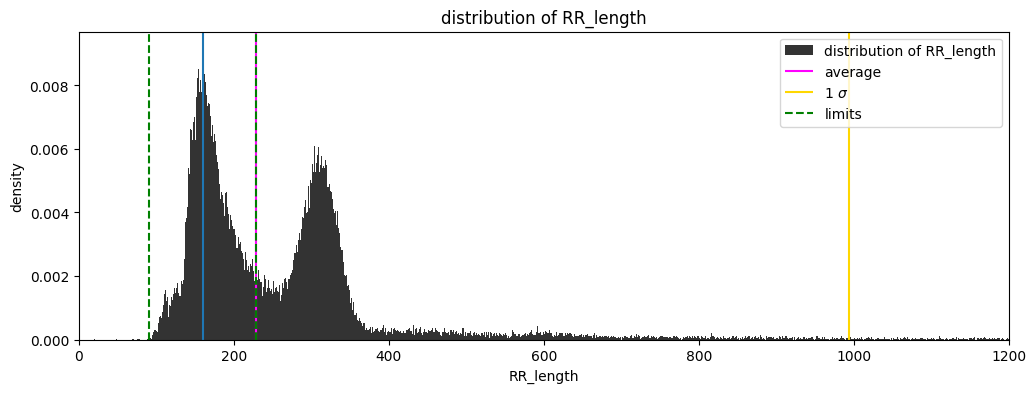

In [234]:
hb = pd.read_csv('output_files/heartbeats.csv')
rr_down_lim, rr_up_lim = distribution2(hb['RR_length'], 0, 1200, title='RR_length', val = 160)

We observe that the distribution has long tails.
Therefore, we decide to discard the heartbeats which values of RR_lenght fall into the tails of the RR_length distribution. 

In [236]:
hb = pd.read_csv('output_files/heartbeats.csv')
ol = len(hb)
# - mean of the std distribution
mean_of_rr= np.mean(hb['RR_length'])
# - sigma of the std distribution
sigma_of_rr=  np.std(hb['RR_length'])
# we then compute the distances from the average in units of sigma 
hb['n_sigma_rr'] = np.abs(hb['RR_length'] - mean_of_rr)/sigma_of_rr # 2 sided

# # finally, we can select the rows by keeping only the rows in which
# hb = hb[(hb["n_sigma_rr"] <= 0.1)].reset_index(drop=True)

# print('percentage of peaks kept: ', round(len(hb)/ol*100,5),'%')
# hb.to_csv('output_files/heartbeats_filtered0.csv', index=False)
# hb

We take only the left peak in the RR length distribution which corresponds to shorter RR length. This choice results in the best hearbeat shape. 

In [238]:
# most_common_length = (info[1])[np.argmax(info[0])]
# diff_to_average = average - most_common_length
# rr_down_lim = int(most_common_length - diff_to_average)
# rr_up_lim = int(most_common_length + diff_to_average)

# finally, we can select the rows by keeping only the rows in which
hb = hb[(hb["RR_length"] >= rr_down_lim)&(hb["RR_length"] <= rr_up_lim)].reset_index(drop=True)

print('percentage of peaks kept: ', round(len(hb)/ol*100,5),'%')
hb.to_csv('output_files/heartbeats_filtered0.csv', index=False)
hb

percentage of peaks kept:  50.00141 %


,patient,idx,start,end,ann_index,RR_length,i,a,v,Delta,n_sigma_rr
0,1,0,667,763,694,136,695.0,0.021833,-5.121537,0.447271,0.216937
1,1,1,804,898,830,134,830.0,0.021400,-4.966572,0.425133,0.219550
2,1,2,938,1031,964,132,964.0,0.022563,-5.065584,0.457178,0.222164
3,1,3,1070,1163,1096,132,1096.0,0.021240,-4.996527,0.424505,0.222164
4,1,5,1603,1700,1630,138,1631.0,0.022747,-5.421619,0.493310,0.214323
...,...,...,...,...,...,...,...,...,...,...,...
35409,24,1818,847295,847385,847320,127,847277.0,-0.021987,3.692612,0.324755,0.228698
35410,24,1819,847417,847523,847447,150,847407.0,-0.017340,4.541612,0.315007,0.198641
35411,24,1820,847574,847657,847597,118,847539.0,-0.022921,4.593035,0.421116,0.240460
35412,24,1821,847691,847778,847715,124,847668.0,-0.029394,6.413937,0.754124,0.232619


We also noticed a correspondance between anomalous/noisy signal in a heartbeat and the corresponding average and standard deviation. 

Therefore, we examine the distributions of these quantities (heartbeat signal average, heartbeat signal standard deviation) by computing their estimators. From those, we decide to discard quantities that differ more than 1$\sigma$ from the corresponding expectation value. This process is one-sided for the standard deviation (since it is non-negative), and two-sided for the average.

The hearbeats are discarded by scrapping the corresponding lines in the hb dataframe. This step is essential to preserving the integrity of the heartbeats that are left. In fact, if this step was to be done before segmentation, the signal would be cropped based on the r-peaks: as a consequence, segmentation would lead to half-heartbeats what would be troublesome in feature extraction.

This process was done for just for the main lead, from which most of the visualizable features were extracted.

In [241]:
hb = pd.read_csv('output_files/heartbeats_filtered0.csv')
# we initialize the values of average and standard deviation
average = np.zeros(len(hb))
sigma = np.zeros(len(hb))
# we recover the information that we need from the hb dataframe as arrays
start = np.array(hb["start"]) 
end = np.array(hb["end"]) 
# we extract the quantities we need
path = "blah"
for beat in range(len(hb)):
    if path != hb["patient"][beat]:
        path = hb["patient"][beat]
        data = pd.read_csv("output_files/data"+str(path)+"_filtered.csv")
        y = np.array(data[main_lead])
    
    average[beat] = np.mean(y[start[beat]:(end[beat]+1)])
    sigma[beat] = np.std(y[start[beat]:(end[beat]+1)])
    if np.isnan(average[beat]) or np.isnan(sigma[beat]):
        print((end[beat]+1)- start[beat])
        
# and add them to the dataframe
hb['average'] = average
hb['sigma'] = sigma

# we can now select the rows based on the distribution
# to do that, we compute the
# - mean of the average distribution
mean_of_average = np.mean(average)
# - sigma of the average distribution
sigma_of_average = np.std(average)
# - mean of the std distribution
mean_of_sigma = np.mean(sigma)
# - sigma of the std distribution
sigma_of_sigma=  np.std(sigma)
# we then compute the distances from the average in units of sigma 
hb['n_sigma_average'] = np.abs(average - mean_of_average)/sigma_of_average # 2 sided
hb['n_sigma_std'] = (sigma - mean_of_sigma)/sigma_of_sigma # 1 sided 
# finally, we can select the rows by keeping only the rows in which
hb = hb[(hb["n_sigma_average"] <= 1) & (hb["n_sigma_std"] <=1)].reset_index(drop=True)
print('percentage of peaks kept: ', round(len(hb)/ol*100,2),'%')
hb.to_csv('output_files/heartbeats_filtered.csv', index=False)
hb

percentage of peaks kept:  42.48 %


,patient,idx,start,end,ann_index,RR_length,i,a,v,Delta,n_sigma_rr,average,sigma,n_sigma_average,n_sigma_std
0,1,5,1603,1700,1630,138,1631.0,0.022747,-5.421619,0.493310,0.214323,-0.050164,1.253226,0.976512,0.104327
1,1,6,1739,1843,1768,147,1769.0,0.022400,-5.391631,0.483091,0.202561,-0.030056,1.214021,0.773147,-0.090741
2,1,7,1886,1989,1915,146,1915.0,0.022183,-5.358755,0.475495,0.203868,-0.030867,1.245937,0.781348,0.068060
3,1,10,3208,3310,3236,145,3236.0,0.022220,-5.284945,0.469724,0.205175,0.013554,1.208109,0.332079,-0.120153
4,1,11,3353,3455,3381,145,3381.0,0.022099,-5.145189,0.454813,0.205175,-0.001347,1.196663,0.482788,-0.177106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30079,24,1816,847037,847128,847062,129,847019.0,-0.016930,3.502978,0.237228,0.226085,0.039249,0.083158,0.072199,-5.717411
30080,24,1817,847166,847257,847191,129,847149.0,-0.021423,3.853764,0.330233,0.226085,0.047095,0.094299,0.007148,-5.661976
30081,24,1818,847295,847385,847320,127,847277.0,-0.021987,3.692612,0.324755,0.228698,0.056552,0.125824,0.102793,-5.505126
30082,24,1820,847574,847657,847597,118,847539.0,-0.022921,4.593035,0.421116,0.240460,-0.012383,0.254795,0.594403,-4.863424


## 4B) Wavelet transform coefficients extraction

The feature extraction using discrete wavelet transform (DWT) is based on the idea presented in the reference [2]. DWT decomposes a signal into detail signal and approximation signal and as a result we obtain for each decomposition level a set of coefficients. Information about QRS complex is mainly concentrated at detail levels 3-5, while information about T and P waves is located at detail levels 6 and 7 [2].

We tried to implement the algorithm with similar decomposition levels, but we receive Warnings that decompostion level was too high. In the end, we settled for 4 decompostion levels, therefore obtaining information about QRS complex. We take approximation signal and detail levels 3-4, which in the end matches proposals discussed in [1]. The idea is that we can extaract features of P and T waves separetly and add them later.

The algorithm for feature extraction using DWT is the following:

1) We firstly determine a fixed size segment near R peak so that the number of decompostion coefficients (thus features) is aslo fixed.

2) We take each segment (beat), perform DWT and return a row of features corresponding to this beat.

We perform this procedure on every lead and save the features in a matrix, where each row corresponds to a particular beat.

In [168]:
def leads_dwt_coeff(hb, lead):
    '''
    function that returns the DWT coefficients of the input lead for all heartbeats
    '''
    # we retrieved the columns of the dataframe that we need
    start = np.array(hb["start"])
    end = np.array(hb["end"])
    R = np.array(hb["ann_index"])
    # we examine the cases that we arbitrarily consider degenerate (to allow for a not-too-small fixed window)
    cond = (hb['idx']==0)
    
    # we find the locations of the beginnings
    j = np.where(hb['idx']==0)[0]
    # and of the ends
    k = np.concatenate([(j -1)[1:],[len(hb)-1]])
    # and find a treshold that can grant us a not-too-small window based based on the histogram of the values
    # (neglecting the lower part of the plt.hist(R[j]-start[j]) and the upper part of the plt.hist(end[k]-R[k])
    temp_start = (R[j]-start[j])>=27
    temp_end =  (end[k]-R[k])>=163
    # and find the indexes corresponding to the degenerate cases
    where_start = np.where(temp_start)[0]
    where_end = np.where(temp_end)[0]
    # so that we can neglect them in finding the fixed window
    fixed_start = R - 30 #np.min((R[j]-start[j])[temp_start]).astype(int)
    fixed_end = R + 90 #np.min((end[k]-R[k])[temp_end]).astype(int)

    path = 'blah'
    # for each patient
    for i in range(0,len(hb)):
        # we make sure to change the file/patient if we have exhausted the previous one
        if path != str(hb["patient"][i]):
            path = str(hb["patient"][i])
            data = pd.read_csv("output_files/data"+path+"_filtered.csv")
            y = np.array(data[lead])
            
        # we select the signal in the fixed window
        z = y[fixed_start[i]:fixed_end[i]]
        # we extract the coefficients
        coeffs = pywt.wavedec(z, 'db4', level=4, axis = 0)
        # we initialize the output to zeros
        if (i == 0):
            l2 = len(coeffs[0])
            l3 = len(coeffs[1])
            l4 = len(coeffs[2])
            # we extract the positions needed to make a single array
            t1 = l2
            t2 = t1 + l3
            t3 = t2 + l4
            features = np.zeros((len(hb), t3))
        # if it's not a degenerate case, we save the result in a row
        if i not in np.concatenate([where_start,where_end]):
            features[i,0:t1]  = coeffs[0]
            features[i,t1:t2] = coeffs[1]
            features[i,t2:t3] = coeffs[2]
        # otherwise we leave zeros

    return features 

In [169]:
parallelization = True
if parallelization:
    n_jobs = -1 #to use all available CPU cores 
    time1 = time.time()
    features_list = Parallel(n_jobs=n_jobs)(delayed(leads_dwt_coeff)(hb, lead) for lead in leads)
    features = np.hstack(features_list)
    time2 = time.time()
    print("the extraction of wavelet features took",round((time2-time1)/60,2),'minutes')
else:
    # If want to do it without parallelization
    for i, lead in enumerate(leads):
        f = leads_dwt_coeff(hb, lead)
        if (i == 0):
            features = f
        else:
            features = np.hstack((features, f))

the extraction of wavelet features took 1.26 minutes


## 4C) Extraction of visualizable features:

### First round of visualizable features

We can now extract the features that were dependent on the ones we just extracted. They consist of:
- the start and end of the QRS complex
- the (real) position and height of the R peak
- the difference (err) between the two estimates of the position of the R peak
- the value and position of the maximum of the heartbeat
- the value and position of the minimum of the heartbeat
- the positive and negative integral of the heartbeat 

We already fitted the peaks found with parabolas and saved their parameters: we just need to convert the saved parameters (which were for linear regression because of the change of variable) to the classic parameters of the parabola

$$  \begin{cases} 
    \begin{matrix}
    y'(j) = a \cdot x + v \\
    x = (i-j)^2
    \end{matrix}
    \end{cases} 
    \;\;\; \Rightarrow \;\;\; 
    y(j) = A\cdot j^2 + B \cdot j + C
$$


As a result, we get that

$$  \begin{cases} 
    \begin{matrix}
    A = a \\
    B = - 2 \cdot a \cdot i \\
    C = v +  a \cdot i^2
    \end{matrix}
    \end{cases} 
    \;\;\; \Rightarrow \;\;\; 
    \Delta = -4 \cdot a \cdot v
$$

so that we can calculate the intesections of the parabola with the x axis and their distance from each other as:

$$ x_\pm = \frac{-B \pm \sqrt{\Delta}}{2A} \;\;\;\;\;\;\;\;\;\;\;\; \delta_x = \frac{\sqrt{\Delta}}{A}  $$

In [242]:
def x_int_points(i,a,v):
    # we find the parabola coefficients from the fit coefficients
    A = a
    B = -2*a*i
    C = v+a*i**2
    Delta = np.sqrt(-4*a*v)
    # we find the intersections
    x_low = (-B-Delta)/(2*A)
    x_up = (-B+Delta)/(2*A)
    # and order them
    temp = np.column_stack([x_low,x_up])
    temp.sort(axis=1)
    x_low = temp[:,0]
    x_up = temp[:,1]
    # and the distance from each other
    delta_x = Delta/A
    return x_low, x_up, delta_x

In [243]:
def integral(y_beat):
    reg_int = np.trapz(y_beat)
    abs_int = np.trapz(np.abs(y_beat))
    pos_int = (reg_int + abs_int)/2
    neg_int = (abs_int - reg_int)/2
    return pos_int, neg_int

In [244]:
hb = pd.read_csv('output_files/heartbeats_filtered.csv')
t1 = time.time()

# we find initialize the variable that we want to retrieve and store into arrays based on their meaning
# - the position of the R_peak found as the local maximum/minimum
x_R_peak = np.zeros(len(hb))    #np.array(hb["ann_index"], dtype = int)
# - the height of the R peak
y_R_peak = np.zeros(len(hb))
# - the coordinates of a point of the peak
x_point = np.zeros(len(hb))
y_point = np.zeros(len(hb))
# - the difference between the annotation index and the actual position of the peak
err = np.zeros(len(hb))
# - the value of the maxima for the entire heartbeat
Ms = np.zeros(len(hb))
# - the index of the maxima for the entire heartbeat
argMs = np.zeros(len(hb))
# - the value of the minima for the entire heartbeat
ms = np.zeros(len(hb))
# - the index of the minima for the entire heartbeat
argms = np.zeros(len(hb))
# - the value of the postive integral for the entire heartbeat
pos_int = np.zeros(len(hb))
# - the value of the negative integral for the entire heartbeat
neg_int = np.zeros(len(hb))

# we then extract the information needed from the dataframe as arrays
# - the start of the heartbeat
start = np.array(hb["start"]) 
# - the end of the heartbeat
end = np.array(hb["end"]) 
# - the RR intervals
RR = np.array(hb["RR_length"])
# - the coefficients of the parabola fits
i = hb['ann_index'].to_numpy()
a = hb['a'].to_numpy()
v = hb['v'].to_numpy()
# - the average
average = np.array(hb['average'])

# we can now do the some of the vectorizable processes:
# we exploit the known proportion QRS:RR = 0.09:0.8 to calculate the expected QRS semi-duration
delta = np.array(RR*0.09/(0.8*2), dtype=int) 

# we save the instances in which the expected QRS semi-duration is null (will be needed later)
skip = np.where(delta ==0)[0]
okay = np.where(delta !=0)[0]
# the expected QRS semi-duration is then used to find the 
start_fit = (hb['ann_index']-delta).astype(int)
end_fit = (hb['ann_index']+delta).astype(int)

# we make sure that the 
print('start < start_fit & end_fit < end :',np.all([start<start_fit, end>end_fit]))

path = "blah"
for beat in range(len(hb)):
    if path != str(hb["patient"][beat]):
        path = str(hb["patient"][beat])
        data = pd.read_csv("output_files/data"+path+"_filtered.csv")
        y = np.array(data[main_lead])
    
    Ms[beat] = np.max(y[start[beat]:(end[beat]+1)])
    ms[beat] = np.min(y[start[beat]:(end[beat]+1)])
    argMs[beat] = np.argmax(y[start[beat]:(end[beat]+1)])
    argms[beat] = np.argmin(y[start[beat]:(end[beat]+1)])
    pos_int[beat], neg_int[beat] = integral(y[start[beat]:(end[beat]+1)])
        
    if (beat in okay):
        # we select the beat
        x0 = np.arange(start[beat],end[beat]+1,1)
        y0 = np.array(y[start[beat]:(end[beat]+1)])
        # we select the absolute of the net signal (obtained by subtracting the noise)
        z = np.abs(y0-average[beat])
        err[beat] = (np.argmax(z)+start[beat]) - x_R_peak[beat]
        # we find the actual R peak (since the annotations aren't always accurate)
        x_R_peak[beat] = np.argmax(z)+start[beat]
        x_fit = np.arange(start_fit[beat],end_fit[beat]+1,1)
        y_fit = np.array(y[start_fit[beat]:(end_fit[beat]+1)])
        # we define
        temp = np.abs(y_fit-average[beat])

        if (y_fit[temp==np.max(temp)]>average[beat]):
            cut_level = average[beat] #+ sigma[beat]
            x_fit = x_fit[y_fit>=cut_level]
            y_fit = y_fit[y_fit>=cut_level]
            y_R_peak[beat] = np.max(y_fit)
            x_R_peak[beat] = x_fit[np.argmax(y_fit)]
            bool_mask = (y_fit>=average[beat])
        else:
            cut_level = average[beat] #- sigma[beat]
            x_fit = x_fit[y_fit<=cut_level]
            y_fit = y_fit[y_fit<=cut_level]
            y_R_peak[beat] = np.min(y_fit)
            x_R_peak[beat] = x_fit[np.argmin(y_fit)]
            bool_mask = (y_fit<=average[beat])
        x_point[beat] = (x_fit[bool_mask])[-1]
        y_point[beat] = (y_fit[bool_mask])[-1]
        
# we finally take care the instances in which the expected QRS semi-duration is null
# such instances are degenerate cases in which (x_point,y_point) will coincide with (x_R_peak,y_R_peak)
x_point[skip] = x_R_peak[skip]
y_point[skip] = y_R_peak[skip]

#QRS_start, QRS_end, QRS = x_intersections_points(x_point, y_point, x_R_peak, y_R_peak, average)
QRS_start, QRS_end, QRS = x_int_points(i,a,v)
print('overflowing from the start: %',len(np.where(QRS_start<start)[0])/len(hb)*100)
print('overflowing from the end: %',len(np.where(QRS_end>end)[0])/len(hb)*100)

t2 = time.time()
print("the extraction of visualizable features took",round((t2-t1)/60,2),'mins')

start < start_fit & end_fit < end : True
overflowing from the start: % 0.0
overflowing from the end: % 0.0
the extraction of visualizable features took 0.8 mins


In [245]:
# before updating the dataframe with the first round of visualizable features, we need to make sure that the indexes 
# found for the start and end of the QRS complex don't exede the indexes for the start and end of the heartbeat
# we find and fix the overflow from the start
condition = (QRS_start < start)
bad = np.where(condition)[0]
QRS_start[bad] = start[bad]
# and we find and fix the overflow from the end
condition = (QRS_end > end)
bad = np.where(condition)[0]
QRS_end[bad] = end[bad]

QRS_start = QRS_start.astype(int)
QRS_end = QRS_end.astype(int)
QRS = QRS.astype(int)
x_R_peak = x_R_peak.astype(int)
argMs = argMs.astype(int)
argms = argms.astype(int)

# so that we can update the dataframe
hb['QRS_start'] = QRS_start
hb["QRS_end"] = QRS_end
hb["QRS_length"] = QRS
hb['x_R_peak'] = x_R_peak
hb["y_R_peak"] = y_R_peak
hb['pos_int'] = pos_int
hb['neg_int'] = neg_int
hb['arg_max'] = argMs
hb['arg_min'] = argms
hb['max'] = Ms
hb['min'] = ms
hb

,patient,idx,start,end,ann_index,RR_length,i,a,v,Delta,...,QRS_end,QRS_length,x_R_peak,y_R_peak,pos_int,neg_int,arg_max,arg_min,max,min
0,1,5,1603,1700,1630,138,1631.0,0.022747,-5.421619,0.493310,...,1645,30,1631,6.241203,27.286423,32.114297,28,33,6.241203,-2.306481
1,1,6,1739,1843,1768,147,1769.0,0.022400,-5.391631,0.483091,...,1783,31,1769,6.324524,27.677816,30.861893,30,35,6.324524,-1.647094
2,1,7,1886,1989,1915,146,1915.0,0.022183,-5.358755,0.475495,...,1930,31,1916,6.176768,28.462620,31.806860,30,35,6.176768,-2.107186
3,1,10,3208,3310,3236,145,3236.0,0.022220,-5.284945,0.469724,...,3251,30,3236,6.224773,28.535936,27.017778,28,34,6.224773,-1.996578
4,1,11,3353,3455,3381,145,3381.0,0.022099,-5.145189,0.454813,...,3396,30,3382,6.222979,27.152976,27.260977,29,34,6.222979,-1.870475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30079,24,1816,847037,847128,847062,129,847019.0,-0.016930,3.502978,0.237228,...,847076,-28,847058,-0.022090,4.122447,0.467157,84,0,0.323828,-0.086825
30080,24,1817,847166,847257,847191,129,847149.0,-0.021423,3.853764,0.330233,...,847204,-26,847188,-0.033164,4.850670,0.480880,5,91,0.326714,-0.062228
30081,24,1818,847295,847385,847320,127,847277.0,-0.021987,3.692612,0.324755,...,847332,-25,847318,-0.061281,6.164660,1.018007,3,90,0.545477,-0.104907
30082,24,1820,847574,847657,847597,118,847539.0,-0.022921,4.593035,0.421116,...,847611,-28,847603,0.106598,6.779662,7.486341,43,79,0.217286,-0.962193


### Second round of visualizable features extraction
We can now also extract the features that were dependent on the ones we just extracted. They consist of:
- the positive and negative integral of the QRS complex
- the start and end of the P peak
- the position and height of the P peak
- the positive and negative integral of the P peak
- the start and end of the T peak
- the position and height of the T peak
- the positive and negative integral of the T peak

In [246]:
# we extract the index/position of the R peak
x_R_peak = hb['x_R_peak']

# we initialize the arrays needed for the second for-loop
# - the positive integral of the QRS complex
r_pos_int = np.zeros(len(hb))
# - the negative integral of the QRS complex
r_neg_int = np.zeros(len(hb))
# - the index of the start of the P peak
p_start = np.zeros(len(hb), dtype=int)
# - the index of the end of the P peak
p_end = np.zeros(len(hb), dtype=int)
# - the index/position of the P peak
x_P_peak = np.zeros(len(hb), dtype=int)
# - the value of the signal in the P peak
y_P_peak = np.zeros(len(hb))
# - the positive integral of P peak
p_pos_int = np.zeros(len(hb))
# - the negative integral of P peak
p_neg_int = np.zeros(len(hb))
# - the index of the start of the T peak
t_start = np.zeros(len(hb), dtype=int)
# - the index of the end of the T peak
t_end = np.zeros(len(hb), dtype=int)
# - the index/position of the T peak
x_T_peak = np.zeros(len(hb), dtype=int)
# - the value of the signal in the T peak
y_T_peak = np.zeros(len(hb))
# - the positive integral of the T peak
t_pos_int = np.zeros(len(hb))
# - the negative integral of the T peak
t_neg_int = np.zeros(len(hb))

# we compute everything that we can do outside of the following for-loops
# particularly, we focus on finding the non-degenerate cases, based on the following conditions
start_condition = (QRS_start > start)
end_condition = (QRS_end < end)
# we find the indexes that correspond to the condition
good_start = np.where(start_condition)[0]
good_end = np.where(end_condition)[0]
# and also the indexes that don't satisfy the condition ("degenerate cases")
bad_start = np.where(np.bitwise_not(start_condition))[0]
bad_end = np.where(np.bitwise_not(end_condition))[0]
# based on the start condition,I set the info for the P peak
# in the non-degenerate cases:
# we set the beginning of P peak as the start of the heartbeat
p_start[good_start] = start[good_start]
# and the end of the P peak as the start of the QRS comples
p_end[good_start] = QRS_start[good_start]
# for the degenerate cases:
# we set both the beginning, end and P peak itself as the start of the heartbeat
p_start[bad_start] = start[bad_start]
p_end[bad_start] = start[bad_start]
x_P_peak[bad_start] = start[bad_start]
# based on the end condition, we set the info for the T peak
# in the non-degenerate cases:
# we set the beginning of T peak as the end of the QRS comples
t_start[good_end] = QRS_end[good_end]
# and the end of the T peak as the end of the heartbeat
t_end[good_end] = end[good_end]
# for the degenerate cases:
# we set both the beginning, end and T peak itself as the end of the heartbeat
t_start[bad_end] = end[bad_end]
t_end[bad_end] = end[bad_end]
x_T_peak[bad_end] = end[bad_end]

In [247]:
######## another loop over beats <- for QRS integrals + P + T + FFT
t1 = time.time()
    
path = "blah"
for beat in range(len(hb)):
    
    if path != str(hb["patient"][beat]):
        path = str(hb["patient"][beat])
        data = pd.read_csv("output_files/data"+path+"_filtered.csv")
        y = np.array(data[main_lead])
        
    ###integrals for QRS    
    y_r = y[QRS_start[beat]:QRS_end[beat]]
    r_pos_int[beat], r_neg_int[beat] = integral(y_r)
    
    ### for P
    if (beat in good_start):
        y_p = y[p_start[beat]:p_end[beat]]
        y_P_peak[beat] = np.max(y_p)
        x_P_peak[beat] = np.argmax(y_p) + p_start[beat]
        p_pos_int[beat], p_neg_int[beat] = integral(y_p)
    else:
        y_P_peak[beat] = y[x_P_peak[beat]]
        p_pos_int[beat], p_neg_int[beat] = 0,0
        
    ### for T  
    if (beat in good_end):
        y_t = y[t_start[beat]:t_end[beat]]
        y_T_peak[beat] = np.max(y_t)
        x_T_peak[beat] = np.argmax(y_t) + t_start[beat]
        t_pos_int[beat], t_neg_int[beat] = integral(y_t)
    else:
        y_T_peak[beat] = y[x_T_peak[beat]]
        t_pos_int[beat], t_neg_int[beat] = 0,0
        
    ### for FFT
#     y_beat = y[fixed_start[beat]:fixed_end[beat]]
#     vect_fft, vect_power, vect_all_freq = power_fft(y_beat, timestep)
#     temp = np.where((vect_all_freq>down_freq_lim) & (vect_all_freq<up_freq_lim))[0]
#     f_keep = vect_power[temp]
#     if beat==0:
#         f = np.zeros((len(hb),len(f_keep)))

#     f[beat, :len(f_keep)] = f_keep
    
t2 = time.time()
print("the algorithm took",round((t2-t1)/60,2),'minutes')  

the algorithm took 0.77 minutes


In [248]:
# we update the dataframe with the newly extracted visualizable features 
hb['r_pos_int'] = r_pos_int
hb['r_neg_int'] = r_neg_int
hb['P_start'] = p_start.astype(int)
hb['P_end'] = p_end.astype(int)
hb['P_length'] = (p_end - p_start).astype(int)
hb['x_P_peak'] = x_P_peak.astype(int)
hb['y_P_peak'] = y_P_peak
hb['P_pos_int'] = p_pos_int
hb['P_neg_int'] = p_neg_int
hb['T_start'] = t_start.astype(int)
hb['T_end'] = t_end.astype(int)
hb['T_length'] = (t_end - t_start).astype(int)
hb['x_T_peak'] = x_T_peak.astype(int)
hb['y_T_peak'] = y_T_peak
hb['T_pos_int'] = t_pos_int
hb['T_neg_int'] = t_neg_int
hb['err'] = hb['ann_index'] - hb['x_R_peak']

hb.to_csv('output_files/heartbeats_full_absolute.csv', index=False)
hb

,patient,idx,start,end,ann_index,RR_length,i,a,v,Delta,...,P_pos_int,P_neg_int,T_start,T_end,T_length,x_T_peak,y_T_peak,T_pos_int,T_neg_int,err
0,1,5,1603,1700,1630,138,1631.0,0.022747,-5.421619,0.493310,...,0.000000,3.296468,1645,1700,55,1666,0.163838,1.245540,5.121461,-1
1,1,6,1739,1843,1768,147,1769.0,0.022400,-5.391631,0.483091,...,0.292587,1.685074,1783,1843,60,1833,-0.008469,0.000000,7.082809,-1
2,1,7,1886,1989,1915,146,1915.0,0.022183,-5.358755,0.475495,...,0.997703,1.459115,1930,1989,59,1988,0.048730,0.263409,4.748557,-1
3,1,10,3208,3310,3236,145,3236.0,0.022220,-5.284945,0.469724,...,0.000000,2.872346,3251,3310,59,3266,0.138747,1.107563,4.883335,0
4,1,11,3353,3455,3381,145,3381.0,0.022099,-5.145189,0.454813,...,0.036477,1.844374,3396,3455,59,3441,0.031338,0.250444,7.208787,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30079,24,1816,847037,847128,847062,129,847019.0,-0.016930,3.502978,0.237228,...,0.757078,0.073372,847076,847128,52,847121,0.323828,2.190158,0.264696,4
30080,24,1817,847166,847257,847191,129,847149.0,-0.021423,3.853764,0.330233,...,2.500342,0.005950,847204,847257,53,847249,0.215554,1.614151,0.094887,3
30081,24,1818,847295,847385,847320,127,847277.0,-0.021987,3.692612,0.324755,...,3.699306,0.000000,847332,847385,53,847376,0.079204,2.192716,0.223051,2
30082,24,1820,847574,847657,847597,118,847539.0,-0.022921,4.593035,0.421116,...,0.000000,0.749987,847611,847657,46,847617,0.217286,3.780919,6.167572,-6


### Looking at some of the visualizable features

To further check the behaviour of the two r-peak finding algorithm that we use (one in the beginning, one in feature extraction)
we can take a look at the the difference (err) between the two estimates of the position of the R peak. 

If the two algorithms work well together, we expect the distirbution to be centered around 0 and be quite tight around it. Different behaviours could be caused by a bias (i.e. average shifted from 0) or by the algorithm not being very precise (i.e. wider distribution/standard deviation)

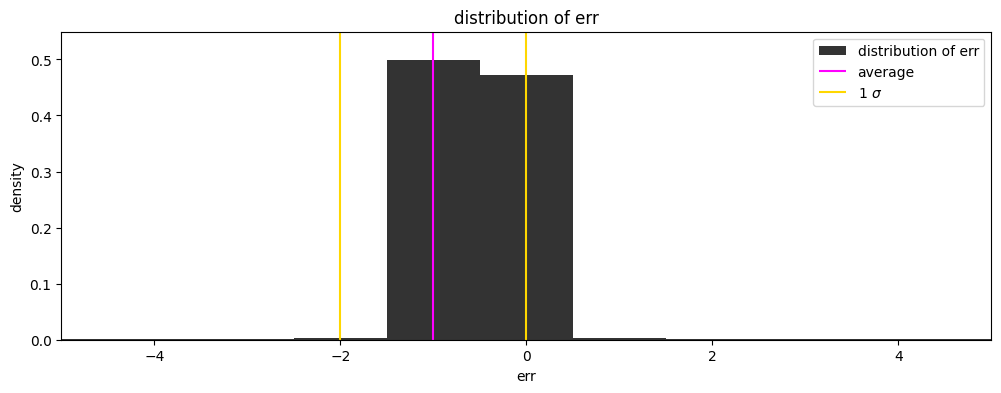

In [249]:
distribution(np.array(hb['err']), -5, 5,title='err')

The R-peak finding algorithm and local minima/maxima algorithm return very similar results.

### Preparing extracted features for ML
Finally, we can adapt the features extracted to be relative to the heartbeat (i.e. not absolute to the entire dataset) but also absolute in terms of time (since future datasets might have different sampling frequencies).

In [215]:
# List of column needed substraction and calculation change to temporal domain
first_change = ['QRS_start', 'QRS_end', 'x_R_peak','P_start', 'P_end', 'x_P_peak', 'T_start', 'T_end', 'x_T_peak']
# List for column needed calculation change calculation to temporal domain
second_change = ['RR_length', 'QRS_length', 'pos_int', 'neg_int', 'arg_max', 'arg_min',  'r_pos_int', 'r_neg_int', 
                 'P_length',  'P_pos_int', 'P_neg_int', 'T_length', 'T_pos_int', 'T_neg_int']

for col in first_change:
    hb[col] = (hb[col] - hb['start'])/new_freq 

for col in second_change:
    hb[col] = hb[col] /new_freq 
    
hb.to_csv('output_files/heartbeats_full_relative.csv', index=False)
hb

,patient,idx,start,end,ann_index,RR_length,i,a,v,Delta,...,P_pos_int,P_neg_int,T_start,T_end,T_length,x_T_peak,y_T_peak,T_pos_int,T_neg_int,err
0,1,5,1603,1700,1630,0.552,1631.0,0.022747,-5.421619,0.493310,...,0.000000,0.013186,0.168,0.388,0.220,0.252,0.163838,0.004982,0.020486,-1
1,1,6,1739,1843,1768,0.588,1769.0,0.022400,-5.391631,0.483091,...,0.001170,0.006740,0.176,0.416,0.240,0.376,-0.008469,0.000000,0.028331,-1
2,1,7,1886,1989,1915,0.584,1915.0,0.022183,-5.358755,0.475495,...,0.003991,0.005836,0.176,0.412,0.236,0.408,0.048730,0.001054,0.018994,-1
3,1,10,3208,3310,3236,0.580,3236.0,0.022220,-5.284945,0.469724,...,0.000000,0.011489,0.172,0.408,0.236,0.232,0.138747,0.004430,0.019533,0
4,1,11,3353,3455,3381,0.580,3381.0,0.022099,-5.145189,0.454813,...,0.000146,0.007377,0.172,0.408,0.236,0.352,0.031338,0.001002,0.028835,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30037,24,1816,847037,847128,847062,0.516,847019.0,-0.016930,3.502978,0.237228,...,0.003028,0.000293,0.156,0.364,0.208,0.336,0.323828,0.008761,0.001059,4
30038,24,1817,847166,847257,847191,0.516,847149.0,-0.021423,3.853764,0.330233,...,0.010001,0.000024,0.152,0.364,0.212,0.332,0.215554,0.006457,0.000380,3
30039,24,1818,847295,847385,847320,0.508,847277.0,-0.021987,3.692612,0.324755,...,0.014797,0.000000,0.148,0.360,0.212,0.324,0.079204,0.008771,0.000892,2
30040,24,1820,847574,847657,847597,0.472,847539.0,-0.022921,4.593035,0.421116,...,0.000000,0.003000,0.148,0.332,0.184,0.172,0.217286,0.015124,0.024670,-6


We can also remove the quantities that won't be ML features since they cannot be relavive to the heartbeat in any way.
Lastly, we convert the dataframe into a numpy matrix, which is put side by side to the matrix with the DWT coefficients. \
In the ML features matrix, each row correspond to an heartbeat.

In [219]:
features_names = list(hb.columns)
no_features = ['patient', 'idx', 'start', 'end', 'ann_index']
for nf in no_features:
    features_names.remove(nf)

hand_extracted_features = hb[features_names]
hand_extracted_features = hand_extracted_features.to_numpy()
ML_input = np.hstack((features, hand_extracted_features))

In [220]:
np.savetxt('output_files/ML_input.txt',ML_input)

In [3]:
ML_input = np.loadtxt('output_files/ML_input.txt')

# 5) Machine Learning

For this dataset, we just need to load the trained model (from ECG_PhysioNet) and have it predict based on the features obtained before:

In [4]:
model_xgb_2 = XGBClassifier()
model_xgb_2.load_model("multi_maxdepth5_nwindow3.json")

In [5]:
num = 2072053
np.random.seed(num)
X = ML_input
Y_pred = model_xgb_2.predict(X)

In [6]:
labels, freqs = np.unique(Y_pred, return_counts=True)

In [7]:
print(labels, freqs)

[0 1] [29937   105]


In [8]:
print('Percentage of sick beats to total beats classifed:', np.round(freqs[1]/sum(freqs)*100,4), '%')

Percentage of sick beats to total beats classifed: 0.3495 %


# 6) Saving output for plotly display

In [40]:
hbb = copy.copy(hb)
def change_values_vectorized(array):
    array = np.where(array==0, 'N', array)
    array = np.where(array=='1', 'V', array)
    array = np.where(array=='2', 'R', array)
    array = np.where(array=='3', 'A', array)
    array = np.where(array=='4', 'other', array)
    return array

Y_label = change_values_vectorized(Y_pred)

hbb['ann_symbol']=Y_label

In [41]:
hbb.to_csv('output_files/everything.csv', index=False)

# References
[0] St Petersburg INCART 12-lead Arrhythmia Database. https://physionet.org/content/incartdb/1.0.0/

[1] A survey of heart anomaly detection using ambulatory electrocardiogram (ECG). Hongzu  Li and Pierre Boulanger. 2020

[2] ECG signal classification using support vector machine based on wavelet multiresolution analysis. Ayman Rabee and Imad Barhumi. 2012.

[3] Segmentation of the ECG Signal by Means of a Linear Regression Algorithm. Javier Aspuru et Al. 2019